# Student Stress Classification

- **Iteration №: 2**
- **Student: Ivan Bodnar**

**Students experience high levels of stress** due to academic pressure, deadlines, and personal challenges. However, **there is currently** no widely accessible, automated **way to assess stress levels and provide personalized feedback** to help students manage their well-being.
In order to solve this problem, **I am aiming to investigate the data** to see the trends, **choose the best-fitting model, and train it to classify students's stress levels**, and, if possible, provide useful feedback.  

---

During my last iteration I have collected the data about the student stress from Fontys students through a google form survey:
https://docs.google.com/forms/d/e/1FAIpQLSe1NUOqiga-TfrjSjefwqrSNO9Jr5bqO_mSAaaqc8q0OSme9g/viewform?usp=sharing

The survey has been constructed from the following:
- **General questions**: how much does the person sleep, how strong is he/she willing to pursue a career based on the current profile, etc.
- **PSS (Perceived Stress Scale)** - questions designed to measure the degree to which situations in persons life are appraised as stressful. I have used a modified version of it, designed for students. 
- **Stress Resistance test** taken from book "Busy, busy, busy", provided by one of the experts I have interviewed
- **Life events** (also taken from book "Busy, busy, busy"), which is a The Holmes and Rahe stress scale, a list of 43 stressful life events that can contribute to illness (which I have cleared so they don't make the questionnaire too long and also match the target audience - students).

**All questions were approved by a university's psychologist**.

In [97]:
# Python version: 3.12.2

# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Data Visualization

# pip install seaborn
import seaborn as sns  
import matplotlib.pyplot as plt 

# Data Preprocessing
from sklearn.preprocessing import StandardScaler  # for feature scaling in specific cases

# Data Splitting and Evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV  # for hyperparameter tuning

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

# Metrics and Evaluation
from sklearn.metrics import classification_report

# Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram  # for plotting dendrograms

# Tree Visualization
from sklearn.tree import _tree  # for accessing decision tree internals
from sklearn.tree import plot_tree  # for visualizing decision trees

# Data Balancing

# pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler  # for oversampling imbalanced datasets

# Google Sheets API

# pip install gspread
import gspread  # for accessing Google Sheets
# pip install oauth2client
from oauth2client.service_account import ServiceAccountCredentials  # for Google Sheets authentication

## Data Provisioning

My survey is connected to a **google sheet** and in order to retrieve the data dynamically I have followed a person smarter than me in this topic (https://www.youtube.com/watch?v=hyUw-koO2DA)

In [98]:
# define the scope and credentials
scopes = ['https://www.googleapis.com/auth/spreadsheets.readonly', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('google-sheets-access/student-stress-457900-e232b54e76fb.json', scopes=scopes)

# authorize and open the workbook
file = gspread.authorize(creds)
workbook = file.open('fontys_student_stress')
sheet = workbook.worksheet('stress')

# get all records from the sheet and convert to a pandas DataFrame
data = sheet.get_all_records()
df = pd.DataFrame(data)

In [99]:
df.to_csv('survey/fontys-stress.csv', index=False)
student_stress = pd.read_csv('survey/fontys-stress.csv')
student_stress.head()

,Позначка часу,How much time do you spend on studying daily? (in hours),Would you like to pursue a career based on your profile/specialization?,Do you have a part time job?,How many hours do you usually sleep?,How would you describe your diet?,"How much time do you spend on physical activities daily (general exercises, any sport counts)?",How often have you felt upset due to something that happened in your academic affairs?,How often you felt as if you were unable to control important things in your academic affairs?,How often you felt nervous and stressed because of academic pressure?,...,I have stomachaches and/or intestinal problems,Have you moved your house in the past 6 month?,Have you had any changes in your lifestyle recently?,Have you had any financial problems lately?,Have you had any sexual problems lately?,Have any of your fellow people been sick (family member or relative) lately?,Have you experienced any injury or sickness lately?,Have you been separated from your family/partner?,"Have you experienced a death of a fellow person (close relative, partner, friend)?","Overall, how would you describe your stress level?"
0,25.04.2025 03:11:16,2.333333,100%,Yes,6.0,Average,2.0,Very often,Fairly often,Fairly often,...,Never,No,Yes,No,No,No,Yes,Yes,Yes,High stress
1,25.04.2025 03:41:40,6.000000,100%,Yes,5.0,Healthy,2.0,Sometimes,Sometimes,Very often,...,Never,No,Yes,No,No,No,No,Yes,Yes,Moderate stress
2,25.04.2025 06:20:56,3.000000,100%,Yes,6.0,Average,1.0,Sometimes,Almost never,Sometimes,...,Sometimes,Yes,Yes,No,No,Yes,No,No,No,Moderate stress
3,25.04.2025 08:12:13,4.000000,100%,Yes,4.0,Unhealthy,0.0,Very often,Very often,Very often,...,Always,No,No,No,No,No,No,Yes,No,High stress
4,25.04.2025 09:13:27,3.000000,50%,No,7.0,Average,0.5,Fairly often,Fairly often,Very often,...,Sometimes,No,No,No,No,No,No,No,No,Moderate stress


Renaming the columns for better readability of the dataset

In [100]:
# i have a ukrainian google account, the google form interface is in ukrainian, so the timestamp column was automatically named in ukranian, my bad(
student_stress.drop(['Позначка часу'], axis=1, inplace=True)

# renaming columns
student_stress.rename(columns={"How much time do you spend on studying daily? (in hours)" : "time_studying"}, inplace=True)
student_stress.rename(columns={"Would you like to pursue a career based on your profile/specialization?" : "career_pursue"}, inplace=True)
student_stress.rename(columns={"Do you have a part time job?" : "part_time_job"}, inplace=True)
student_stress.rename(columns={"How many hours do you usually sleep?" : "time_sleep"}, inplace=True)
student_stress.rename(columns={"How would you describe your diet?" : "diet"}, inplace=True)
student_stress.rename(columns={"How much time do you spend on physical activities daily (general exercises, any sport counts)?" : "time_physical_activities"}, inplace=True)
student_stress.rename(columns={"How often have you felt upset due to something that happened in your academic affairs?" : "upset_academic_affairs"}, inplace=True)
student_stress.rename(columns={"How often you felt as if you were unable to control important things in your academic affairs?" : "unable_control_academic_affairs"}, inplace=True)
student_stress.rename(columns={"How often you felt nervous and stressed because of academic pressure?" : "nervous_academic_pressure"}, inplace=True)
student_stress.rename(columns={"How often you felt as if you could not cope with all the mandatory academic activities? (assignments, project requirements, etc.)" : "unable_cope_academic_activities"}, inplace=True)
student_stress.rename(columns={"How often you felt confident about your ability to handle your academic / university problems?" : "confident_handle_academic_problems"}, inplace=True)
student_stress.rename(columns={"How often you felt as if things in your academic life is going on your way?" : "things_going_on_way"}, inplace=True)
student_stress.rename(columns={"How often are you able to control irritations in your academic / university affairs?" : "control_irritations_academic_affairs"}, inplace=True)
student_stress.rename(columns={"How often you felt as if your academic performance was on top?" : "academic_performance_top"}, inplace=True)
student_stress.rename(columns={"How often you got angered due to bad performance or low grades that is beyond your control?" : "angered_bad_performance"}, inplace=True)
student_stress.rename(columns={"How often you felt as if academic difficulties are piling up so high that you could not overcome them?" : "academic_difficulties_piling_up"}, inplace=True)
student_stress.rename(columns={"I am never completely satisfied with my achievements" : "never_satisfied_achievements"}, inplace=True)
student_stress.rename(columns={"I am quickly irritated by other people" : "quickly_irritated_people"}, inplace=True)
student_stress.rename(columns={"The future seems gloomy to me" : "future_gloomy"}, inplace=True)
student_stress.rename(columns={"I quickly become impatient" : "quickly_impatient"}, inplace=True)
student_stress.rename(columns={"I smoke too much" : "smoke_too_much"}, inplace=True)
student_stress.rename(columns={"I find it hard to think clearly when I am in a difficult situation" : "hard_think_clearly"}, inplace=True)
student_stress.rename(columns={"I often feel rushed in my work " : "often_rushed_work"}, inplace=True)
student_stress.rename(columns={"I am not sleeping well" : "not_sleeping_well"}, inplace=True)
student_stress.rename(columns={"I am sensitive to noise" : "sensitive_noise"}, inplace=True)
student_stress.rename(columns={"I find criticism difficult and I don't deal with it well" : "find_criticism_difficult"}, inplace=True)
student_stress.rename(columns={"I often have panic attacks " : "panic_attacks"}, inplace=True)
student_stress.rename(columns={"I have stomachaches and/or intestinal problems" : "stomachaches"}, inplace=True)
student_stress.rename(columns={"Have you moved your house in the past 6 month?" : "moved_house"}, inplace=True)
student_stress.rename(columns={"Have you had any changes in your lifestyle recently?" : "changes_lifestyle"}, inplace=True)
student_stress.rename(columns={"Have you had any financial problems lately?" : "financial_problems"}, inplace=True)
student_stress.rename(columns={"Have you had any sexual problems lately?" : "sexual_problems"}, inplace=True)
student_stress.rename(columns={"Have any of your fellow people been sick (family member or relative) lately?" : "fellow_people_sick"}, inplace=True)
student_stress.rename(columns={"Have you experienced any injury or sickness lately?" : "experienced_injury"}, inplace=True)
student_stress.rename(columns={"Have you been separated from your family/partner?" : "separated_family"}, inplace=True)
student_stress.rename(columns={"Have you experienced a death of a fellow person (close relative, partner, friend)?" : "experienced_death"}, inplace=True)
student_stress.rename(columns={"Overall, how would you describe your stress level?" : "stress_level"}, inplace=True)

student_stress.head(5)

,time_studying,career_pursue,part_time_job,time_sleep,diet,time_physical_activities,upset_academic_affairs,unable_control_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,...,stomachaches,moved_house,changes_lifestyle,financial_problems,sexual_problems,fellow_people_sick,experienced_injury,separated_family,experienced_death,stress_level
0,2.333333,100%,Yes,6.0,Average,2.0,Very often,Fairly often,Fairly often,Fairly often,...,Never,No,Yes,No,No,No,Yes,Yes,Yes,High stress
1,6.000000,100%,Yes,5.0,Healthy,2.0,Sometimes,Sometimes,Very often,Sometimes,...,Never,No,Yes,No,No,No,No,Yes,Yes,Moderate stress
2,3.000000,100%,Yes,6.0,Average,1.0,Sometimes,Almost never,Sometimes,Almost never,...,Sometimes,Yes,Yes,No,No,Yes,No,No,No,Moderate stress
3,4.000000,100%,Yes,4.0,Unhealthy,0.0,Very often,Very often,Very often,Very often,...,Always,No,No,No,No,No,No,Yes,No,High stress
4,3.000000,50%,No,7.0,Average,0.5,Fairly often,Fairly often,Very often,Fairly often,...,Sometimes,No,No,No,No,No,No,No,No,Moderate stress


Saving the dataset to a csv file to have an overview of the data

In [101]:
student_stress.to_csv('survey/fontys-stress.csv', index=False)

Checking the data types with info()

In [102]:
student_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   time_studying                         38 non-null     float64
 1   career_pursue                         38 non-null     object 
 2   part_time_job                         38 non-null     object 
 3   time_sleep                            38 non-null     float64
 4   diet                                  38 non-null     object 
 5   time_physical_activities              38 non-null     float64
 6   upset_academic_affairs                38 non-null     object 
 7   unable_control_academic_affairs       38 non-null     object 
 8   nervous_academic_pressure             38 non-null     object 
 9   unable_cope_academic_activities       38 non-null     object 
 10  confident_handle_academic_problems    38 non-null     object 
 11  things_going_on_way  

Checking overall information about the collected dataset with describe()

In [103]:
student_stress.describe()

,time_studying,time_sleep,time_physical_activities
count,38.000000,38.000000,38.000000
mean,4.692982,6.717105,1.492105
std,2.452408,1.118292,1.772063
min,1.000000,4.000000,0.000000
25%,3.000000,6.000000,0.625000
50%,4.000000,7.000000,1.000000
75%,6.000000,7.562500,2.000000
max,10.000000,8.500000,10.000000


Check the distribution of the target variable - stress_level

stress_level
Moderate stress    20
High stress        10
Low stress          8
Name: count, dtype: int64


<Axes: xlabel='stress_level'>

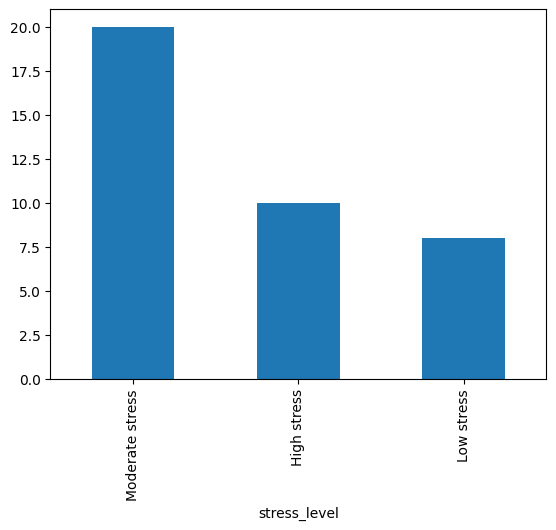

In [104]:
print(student_stress['stress_level'].value_counts())
student_stress['stress_level'].value_counts().plot(kind='bar')

The thing about my collected data is that logically it is meant to represent linear relationships (answers usually vary from Never to Very often) but it is categorical, so the usual ways of showing linear relations would not work (the scatter plot for example will just show a grid, even if there is a linear relationship)

Thats why, in order to analyze the data, I will use several techniques:
- box plots mostly for general data
- box plots for categorical data to present the frequency in feature and target categories (after all, my problem is classification)
- cross tab also for categorical data to present the frequencies in feature and target categories in numerical view (in case box plots would not show anything useful)

Another thing I discovered and used in my previous iteration is technique from statistics - chi-square test, which is a good metric for discovering if a categorical feature has any relationship with categorical target variable, but unfortunately my dataset is too small for this method to calculate useful results. 

**I have to do a big remark. So, I have called a 'linear relationship" (above and below in each feature analysis), as it was the closest association I had from my knowledge, is not linear. Most likely, it is a monotonic trend, where the higher values of one variable tend to be associated with higher values of another**

### General questions

#### time_studying

How much time does a student spend on studying daily?

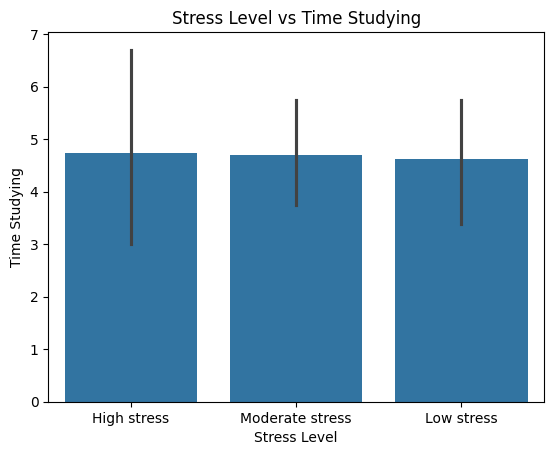

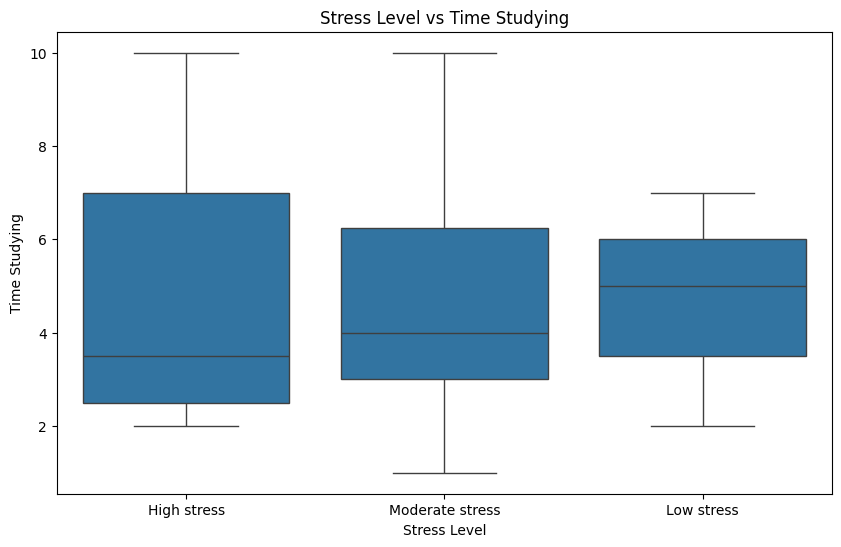

In [105]:
x = student_stress['stress_level']
y = student_stress['time_studying']
plot = sns.barplot(x=x, y=y)
plt.title('Stress Level vs Time Studying')
plt.xlabel('Stress Level')
plt.ylabel('Time Studying')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, y='time_studying', x='stress_level')
plt.title('Stress Level vs Time Studying')
plt.xlabel('Stress Level')
plt.ylabel('Time Studying')
plt.show()

The bar plot doesn't give much useful information, every stress level reaches the same scale of time studying. However looking at the boxplot it can be seen that the medians of each stress level is increasing (considering the order of categories on the plot) as the mean study time decreases (High stress students spend approximately 3.7 hours daily on studying, moderate stress - 4 hours, low stress - 5 hours). Because the distribution of high and moderate levels is widely spread, the feature might not have useful relationship with the target variable

#### career_pursue

How strong does a person want to pursue a career based on their profile/specialization?

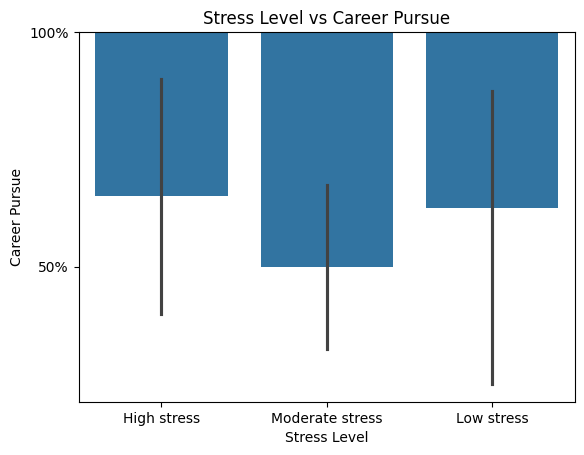

In [106]:
x = student_stress['stress_level']
y = student_stress['career_pursue']
plot = sns.barplot(x=x, y=y)
plt.title('Stress Level vs Career Pursue')
plt.xlabel('Stress Level')
plt.ylabel('Career Pursue')
plt.show()

The bar plot looks strange, but makes sense (individually). If we look at the dataset, it can be seen that there are no records of students whose willingness to pursue a career based on their current study route are less than 50% (the options for this question was 0%, 25%, 50%, 75%, 100%). From the plot it can be seen that students with high and low stress levels tend to want to pursue career at least 75%, while some of moderate stress students are at 50% willingness. I consider that this feature has too low correlation with the target variable. 

#### part_time_job

Does a student have a part time job?

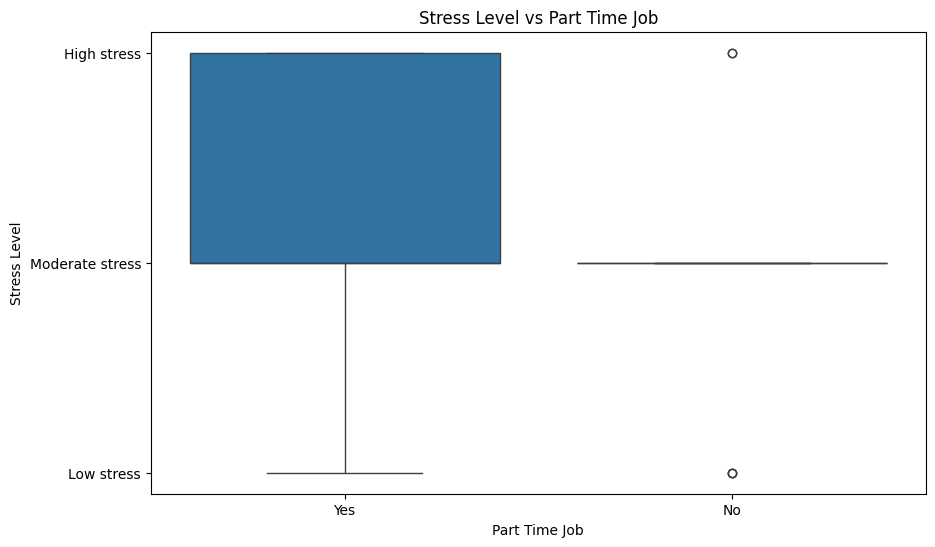

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='part_time_job', y='stress_level')
plt.title('Stress Level vs Part Time Job')
plt.xlabel('Part Time Job')
plt.ylabel('Stress Level')
plt.show()

The boxplot indicates that students who have part time job have a wide range of stress levels, most of each are in moderate and high stress sections, while for students without job the mean is in the moderate stress section with outliers in high and low stress, which might indicate that unemployed students with low stress probably have a good time management fro studying or have a calm life, and unemployed students with high stress are probably under pressure for different reason other than combining studies with work.

#### time_sleep

How many hours does a student usually sleep?

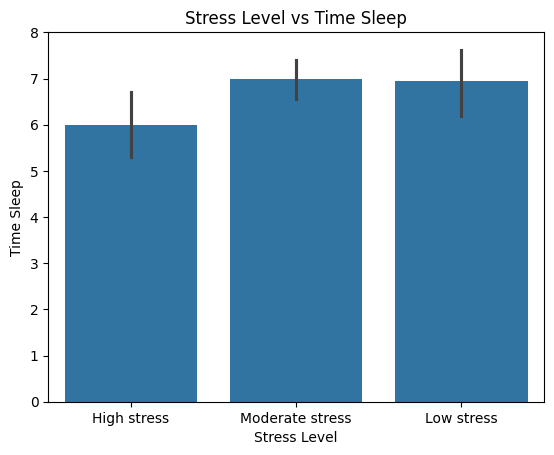

In [108]:
x = student_stress['stress_level']
y = student_stress['time_sleep']
plot = sns.barplot(x=x, y=y)
plt.title('Stress Level vs Time Sleep')
plt.xlabel('Stress Level')
plt.ylabel('Time Sleep')
plt.show()

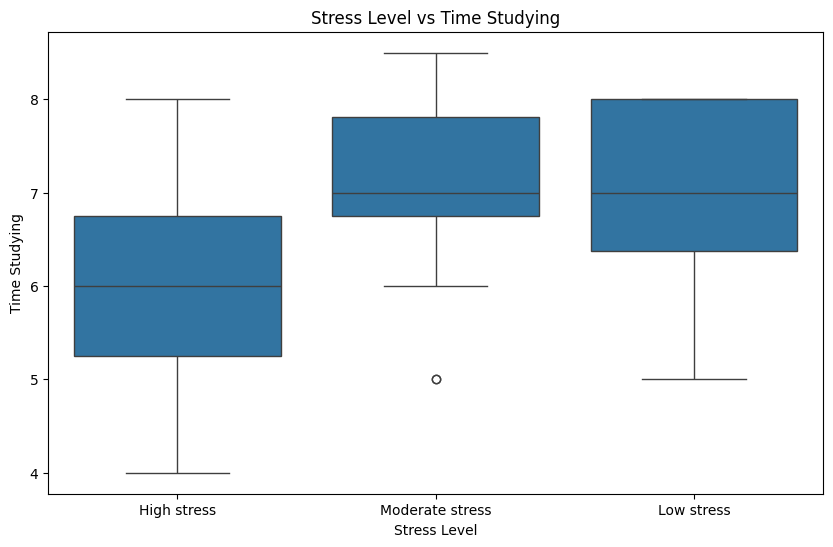

In [109]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, y='time_sleep', x='stress_level')
plt.title('Stress Level vs Time Studying')
plt.xlabel('Stress Level')
plt.ylabel('Time Studying')
plt.show()

The main points from these plots are that:
- Students with high stress tend sleep less, even though the answers range a lot
- Students with moderate stress usually sleep more, but there still are some students who sleep the same amount as high stress students
- Students with low stress tend to sleep the most.

It can be stated that "the less a student sleeps, the higher is their stress level".

#### diet

How does a student describe their diet?

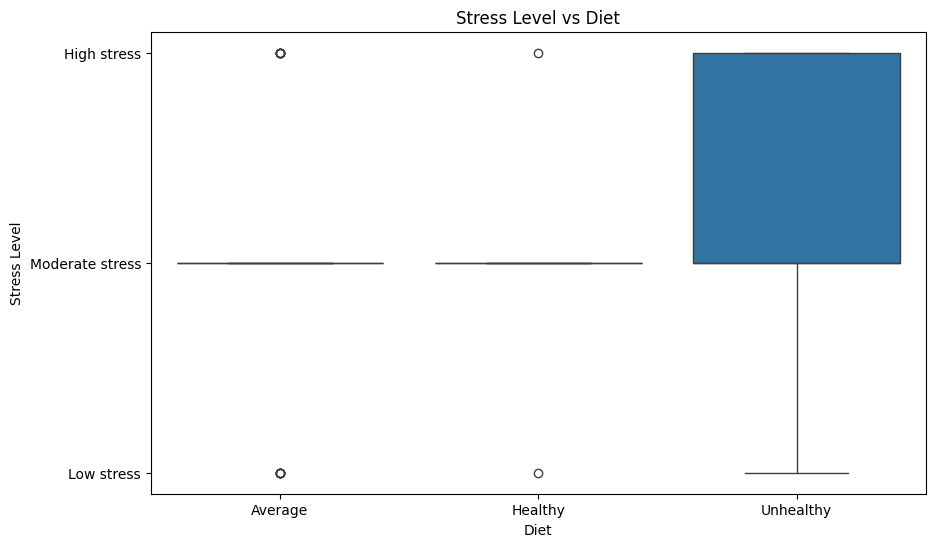

In [110]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='diet', y='stress_level')
plt.title('Stress Level vs Diet')
plt.xlabel('Diet')
plt.ylabel('Stress Level')
plt.show()

For diet feature does not contain useful information, as the means of all diet categories are at Moderate stress level with outliers and the Unhealthy category ranges a lot. I think that this feature might just generate noise for the model.

#### time_physical_activities

How much time does a student spend on physical activities daily?

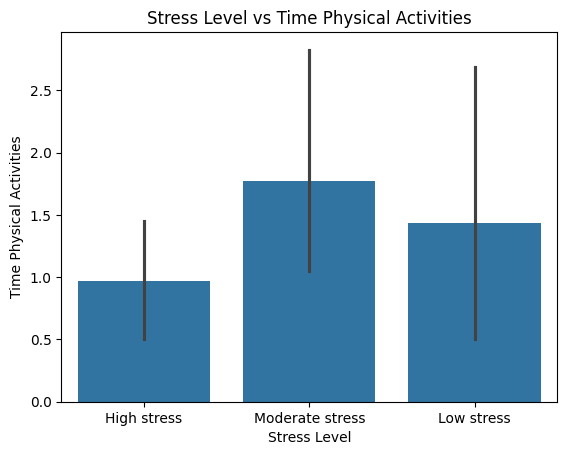

In [111]:
x = student_stress['stress_level']
y = student_stress['time_physical_activities']
plot = sns.barplot(x=x, y=y)
plt.title('Stress Level vs Time Physical Activities')
plt.xlabel('Stress Level')
plt.ylabel('Time Physical Activities')
plt.show()

The bar plot shows that students who spend little time on physical activities tend to have high stress level.

### PSS

#### upset_academic_affairs

How often has a student felt upset due to something that happened in their academic affairs?

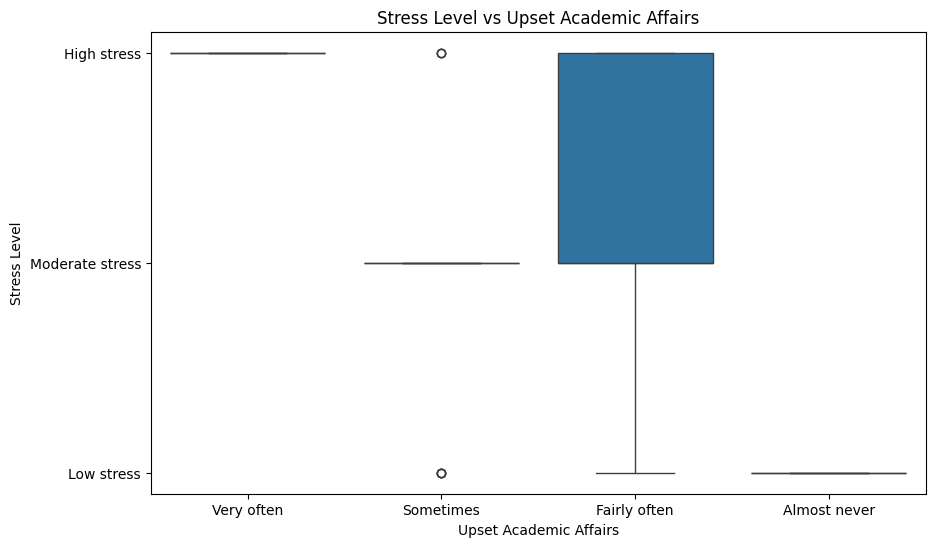

In [112]:
# upset_academic_affairs,unable_control_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,confident_handle_academic_problems,
# things_going_on_way,control_irritations_academic_affairs,academic_performance_top,angered_bad_performance,academic_difficulties_piling_up
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='upset_academic_affairs', y='stress_level')
plt.title('Stress Level vs Upset Academic Affairs')
plt.xlabel('Upset Academic Affairs')
plt.ylabel('Stress Level')
plt.show()

The box plot shows almost linear relationship between upset_academic_affairs and stress level. The means of each answer represent (from Almost never to Very often) represent higher stress levels. One thing that ranges is the Fairly often category.

#### unable_control_academic_affairs

How often has a student felt as if they were unable to control important things in their academic affairs?

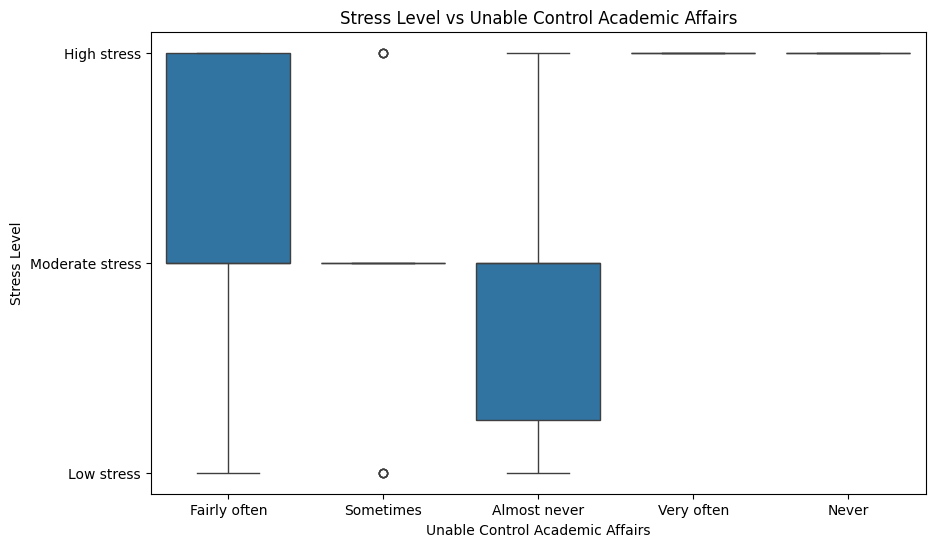

In [113]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='unable_control_academic_affairs', y='stress_level')
plt.title('Stress Level vs Unable Control Academic Affairs')
plt.xlabel('Unable Control Academic Affairs')
plt.ylabel('Stress Level')
plt.show()

The results of unable_control_academic_affairs are not what I was expecting. I thought that the results would be close to the previous feature (upset_academic_affairs), but apparently even students who are able to control important things in their academic affairs are experiencing high stress. What can I say, Fontys students XD

#### nervous_academic_pressure

How often has a student felt nervous and stressed because of academic pressure?

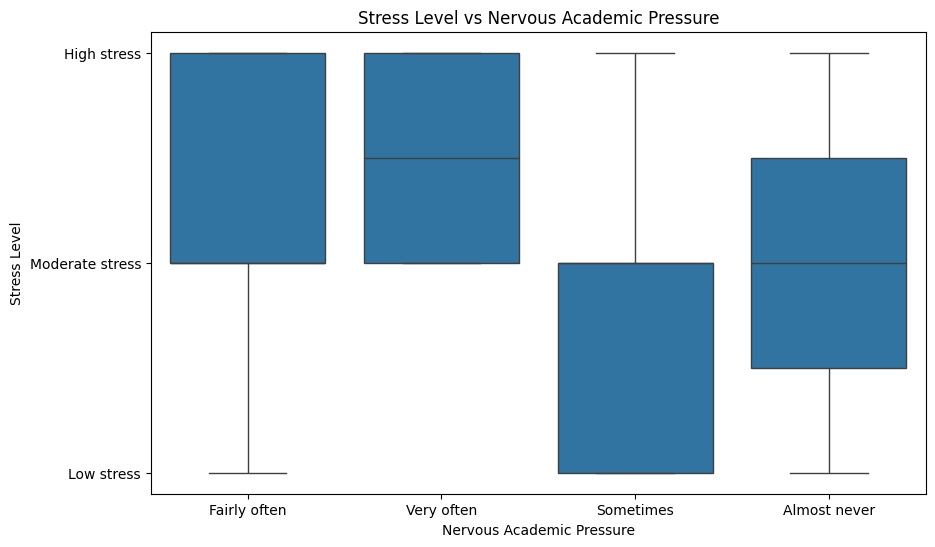

In [114]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='nervous_academic_pressure', y='stress_level')
plt.title('Stress Level vs Nervous Academic Pressure')
plt.xlabel('Nervous Academic Pressure')
plt.ylabel('Stress Level')
plt.show()

One thing I have discovered from my interview with university's psychologist is that usually questions about (how person feels) indicate stress better. However, so far 2 of these questions have failed me. From the plot above it can be concluded that even people who almost never felt nervous and/or stressed because of academic pressure still tend to have higher stress level (by "higher" I mean not Low stress level)

#### unable_cope_academic_activities

How often has a student felt as if they could not cope with all the mandatory academic activities?

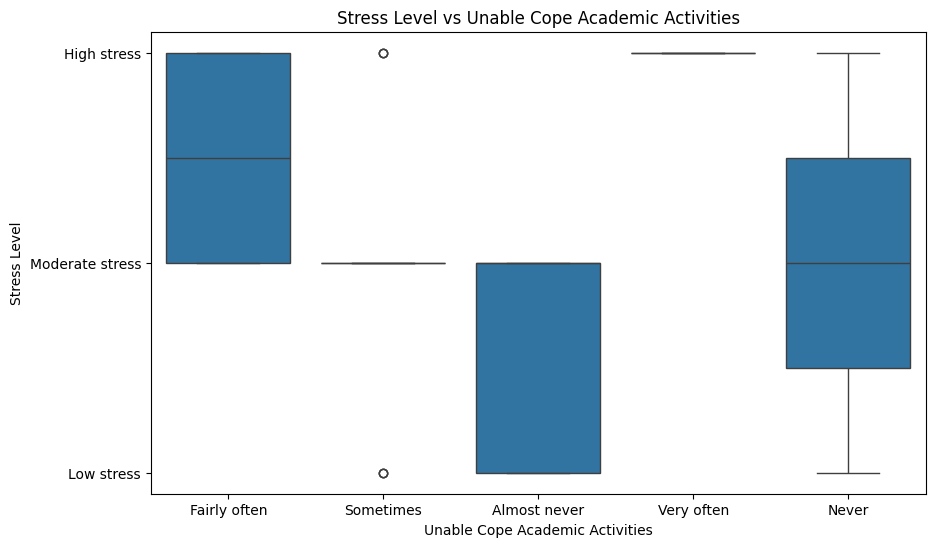

In [115]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='unable_cope_academic_activities', y='stress_level')
plt.title('Stress Level vs Unable Cope Academic Activities')
plt.xlabel('Unable Cope Academic Activities')
plt.ylabel('Stress Level')
plt.show()

unable_cope_academic_activities feature has better relationship with the target variable:
- "Very often" category refers to high stress
- "Fairly often category ranges from moderate to high stress
- "Sometimes" mean refers to just moderate stress level (with outliers in low and high stress, but again, this might be that there are other stressors for particular people)
- I would expect "Almost never" and "Never" categories to switch their results, but this still make sense

#### confident_handle_academic_problems

How often has a student felt confident about their ability to handle their academic / university problems?

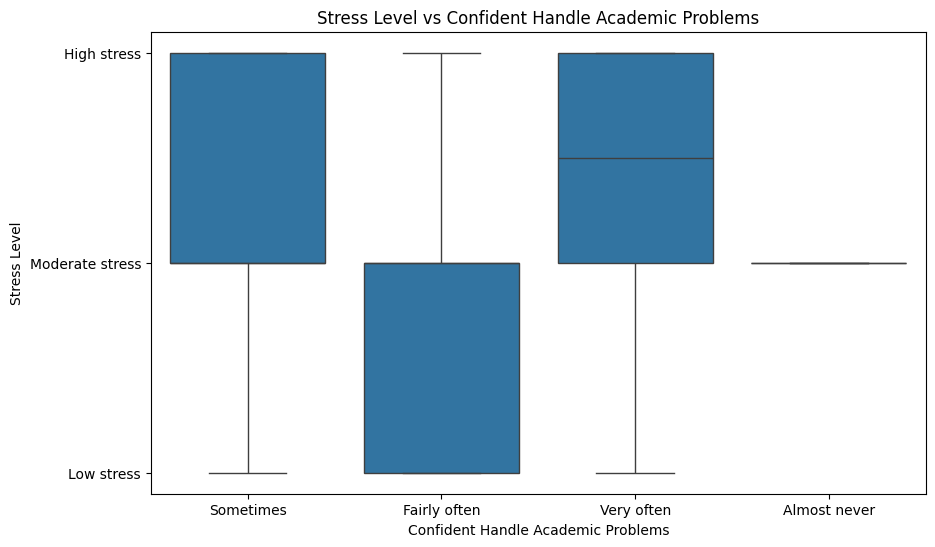

In [116]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='confident_handle_academic_problems', y='stress_level')
plt.title('Stress Level vs Confident Handle Academic Problems')
plt.xlabel('Confident Handle Academic Problems')
plt.ylabel('Stress Level')
plt.show()

The question was meant to show almost linear relation with the target variable. However, the plot contains rather scrambled information:
- "Very often" category states that students who are confident about their ability to handle academic problems tend to have High stress, which is the opposite of what I expected
- "Fairly often" category is what I more or less expected - the data ranges from Low to Moderate stress
- "Sometimes" category is also what I have predicted, even though the data ranges through 2 levels (I expected it to be a "medium" answer, staying either at just moderate stress or range from low to moderate)
- "Almost never category" was expected.

My assumption that "Students who are confident about their ability to handle academic problems tend to have low stress level" is not completely true, judging from the data.

#### things_going_on_way

How often has a student felt as if things in their academic life were going on their way?

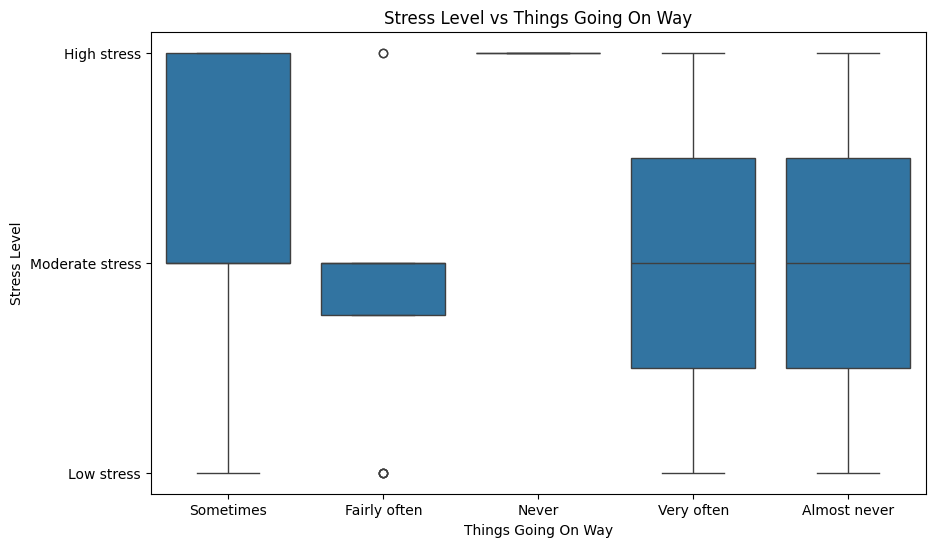

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='things_going_on_way', y='stress_level')
plt.title('Stress Level vs Things Going On Way')
plt.xlabel('Things Going On Way')
plt.ylabel('Stress Level')
plt.show()

The results of things_going_on_way have scrambled results. looking at the question I would assume that the result would be "students who felt that things in their academic life were going on their way would experience lower stress" can not be stated as neither true or false, as the frequencies range. Only categories that make sense are "Never"(high stress) and "Fairly often"(moderate to low stress)

#### control_irritations_academic_affairs

How often was the student been able to control irritations in their academic / university affairs?

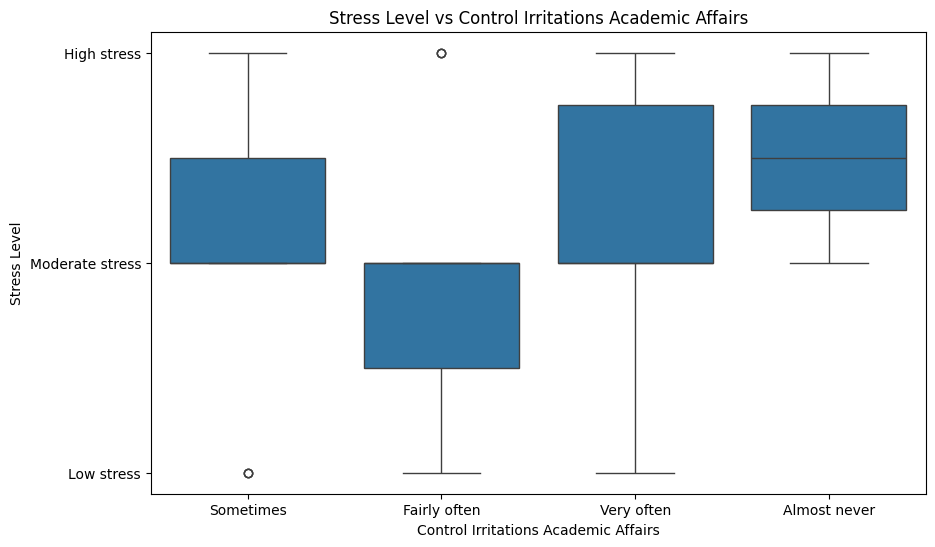

In [118]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='control_irritations_academic_affairs', y='stress_level')
plt.title('Stress Level vs Control Irritations Academic Affairs')
plt.xlabel('Control Irritations Academic Affairs')
plt.ylabel('Stress Level')
plt.show()

From the results of the boxplot the only thing I can state is that there is almost no relation to the target variable - logically opposite answers have high stress level. The only thing that makes sense is the "Fairly often".

#### academic_performance_top

How often has a student felt as if their academic performance was on top?

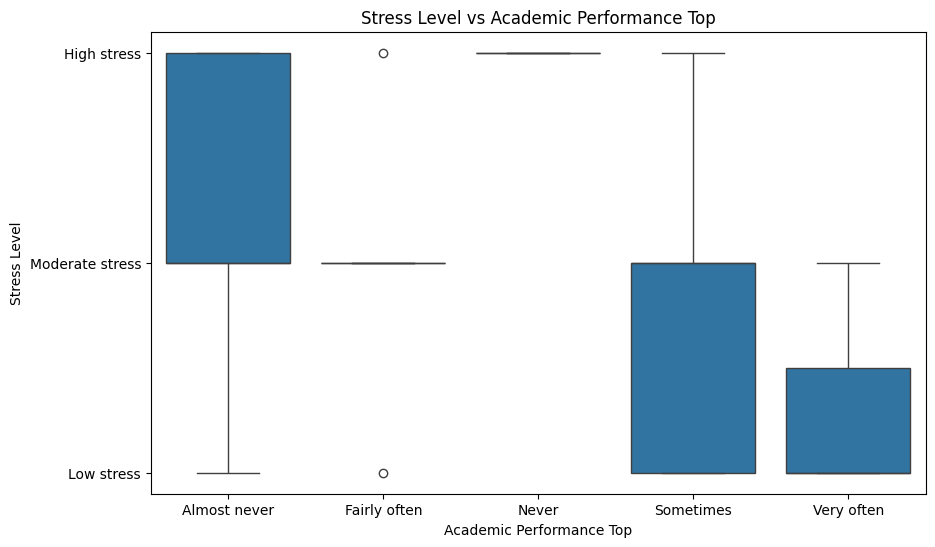

In [119]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='academic_performance_top', y='stress_level')
plt.title('Stress Level vs Academic Performance Top')
plt.xlabel('Academic Performance Top')
plt.ylabel('Stress Level')
plt.show()

academic_performance_top almost represents negative linear relationship. "Never" categories represent High stress level, "Often" - Low stress level

#### angered_bad_performance

How often has a student gotten angered due to bad performance or low grades that is beyond their control?

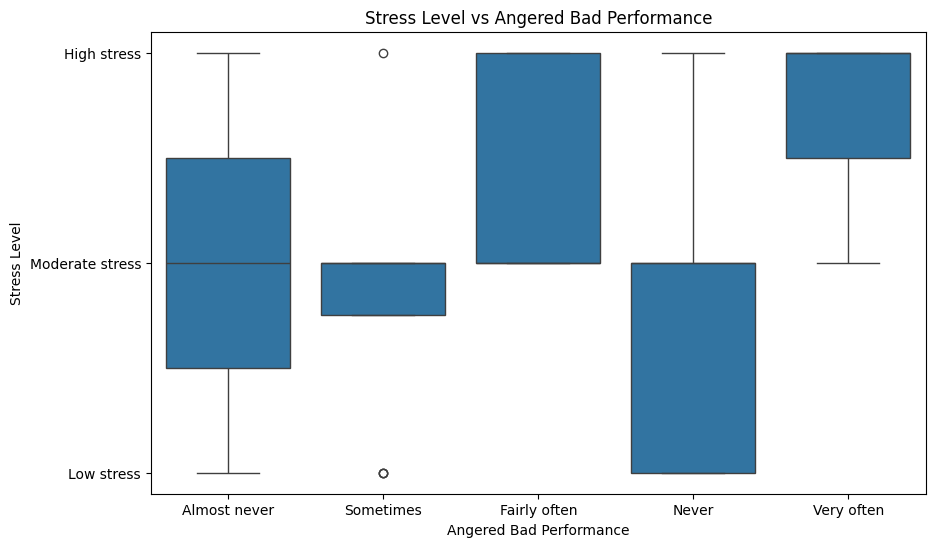

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='angered_bad_performance', y='stress_level')
plt.title('Stress Level vs Angered Bad Performance')
plt.xlabel('Angered Bad Performance')
plt.ylabel('Stress Level')
plt.show()

The box plot represents decent relationship. Even though "Almost never" category ranges a lot, the other categories look good: "The more often a student gets angered due to bad performance, the higher the stress level is"

#### academic_difficulties_piling_up

How often has a student felt as if academic difficulties are piling up so high that they could not overcome them?

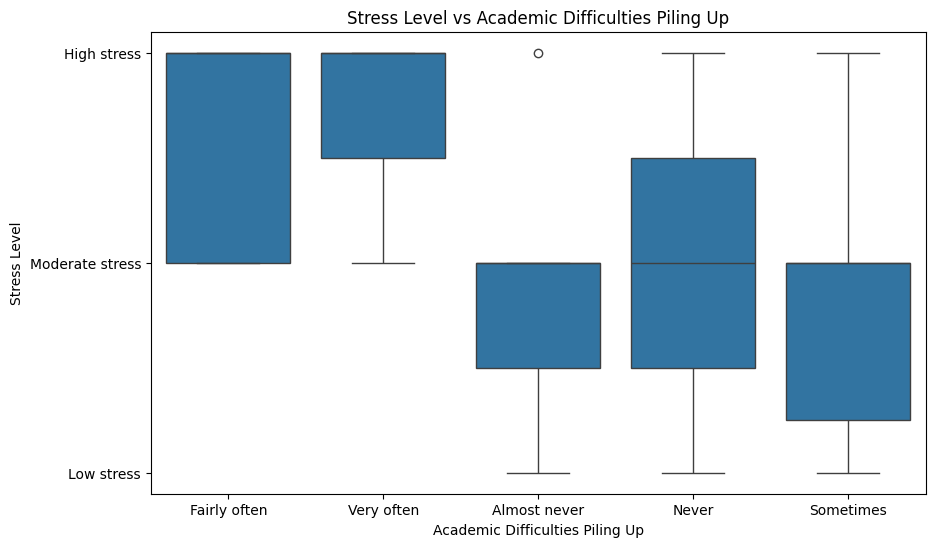

In [121]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='academic_difficulties_piling_up', y='stress_level')
plt.title('Stress Level vs Academic Difficulties Piling Up')
plt.xlabel('Academic Difficulties Piling Up')
plt.ylabel('Stress Level')
plt.show()

I have expected the plot to show strong linear relationship, but as some categories have a wide range through stress levels, which partially rejects my statement. 

### Stress resistance

#### never_satisfied_achievements

"I am never completely satisfied with my achievements"

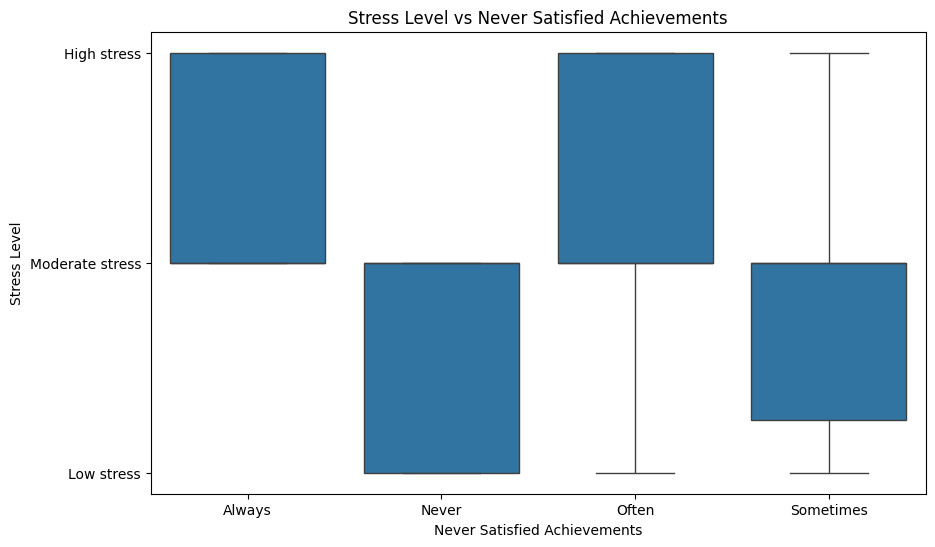

In [122]:
# never_satisfied_achievements,quickly_irritated_people,future_gloomy,quickly_impatient,smoke_too_much,hard_think_clearly,often_rushed_work,not_sleeping_well,sensitive_noise,find_criticism_difficult,panic_attacks,stomachaches
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='never_satisfied_achievements', y='stress_level')
plt.title('Stress Level vs Never Satisfied Achievements')
plt.xlabel('Never Satisfied Achievements')
plt.ylabel('Stress Level')
plt.show()

never_satisfied_achievements presents a decent linear relationship, as even though some categories range, the IQR is at the right places: Never at low to moderate, Always at moderate to high.

#### quickly_irritated_people

"I am quickly irritated by other people"

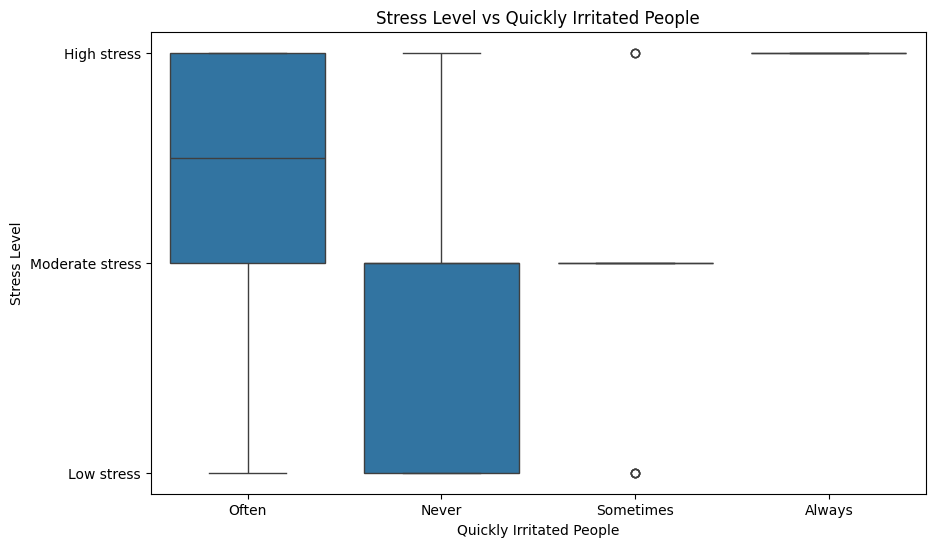

In [123]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='quickly_irritated_people', y='stress_level')
plt.title('Stress Level vs Quickly Irritated People')
plt.xlabel('Quickly Irritated People')
plt.ylabel('Stress Level')
plt.show()

quickly_irritated_people also represents a decent density in each category

#### future_gloomy

"The future seems gloomy to me"

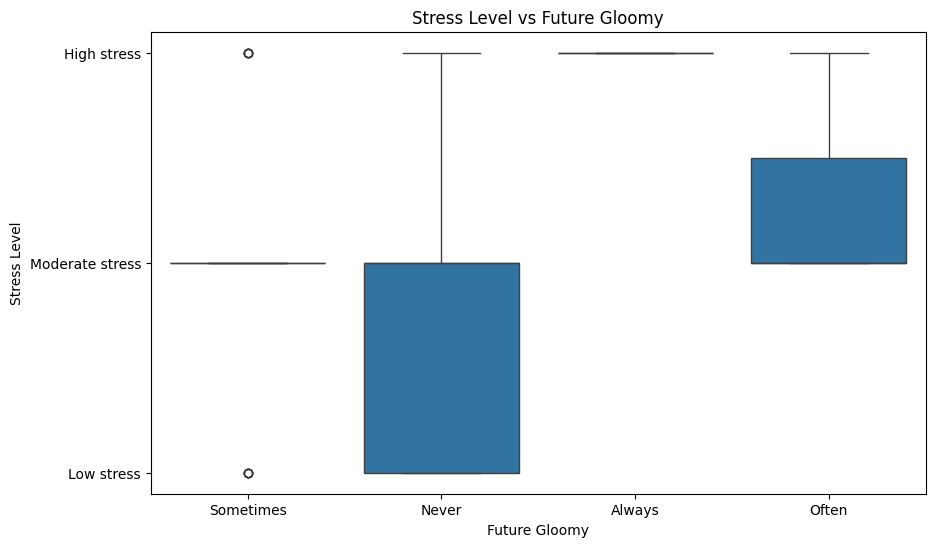

In [124]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='future_gloomy', y='stress_level')
plt.title('Stress Level vs Future Gloomy')
plt.xlabel('Future Gloomy')
plt.ylabel('Stress Level')
plt.show()

Same situation as in the plots above, decent relation

#### quickly_impatient

"I quickly become impatient"

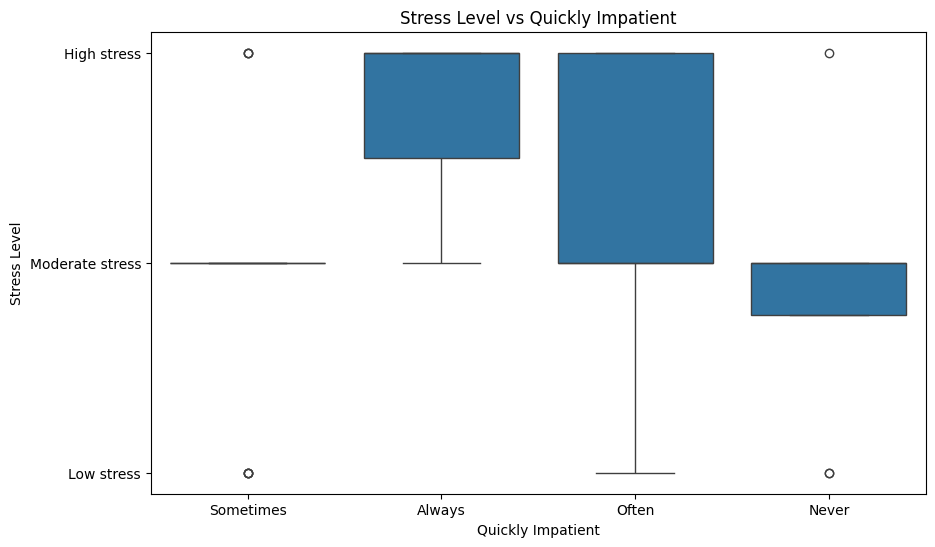

In [125]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='quickly_impatient', y='stress_level')
plt.title('Stress Level vs Quickly Impatient')
plt.xlabel('Quickly Impatient')
plt.ylabel('Stress Level')
plt.show()

The density is a bit scrambled, but the categories separation still makes sense

#### smoke_too_much

"I smoke too much"

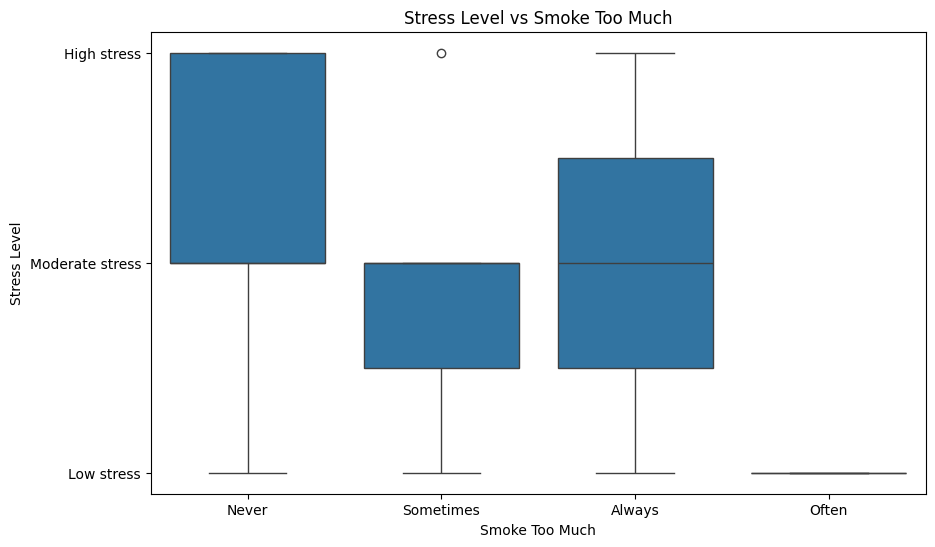

In [126]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='smoke_too_much', y='stress_level')
plt.title('Stress Level vs Smoke Too Much')
plt.xlabel('Smoke Too Much')
plt.ylabel('Stress Level')
plt.show()

Students who smoke too much often experience less stress

#### hard_think_clearly

"I find it hard to think clearly when I am in a difficult situation"

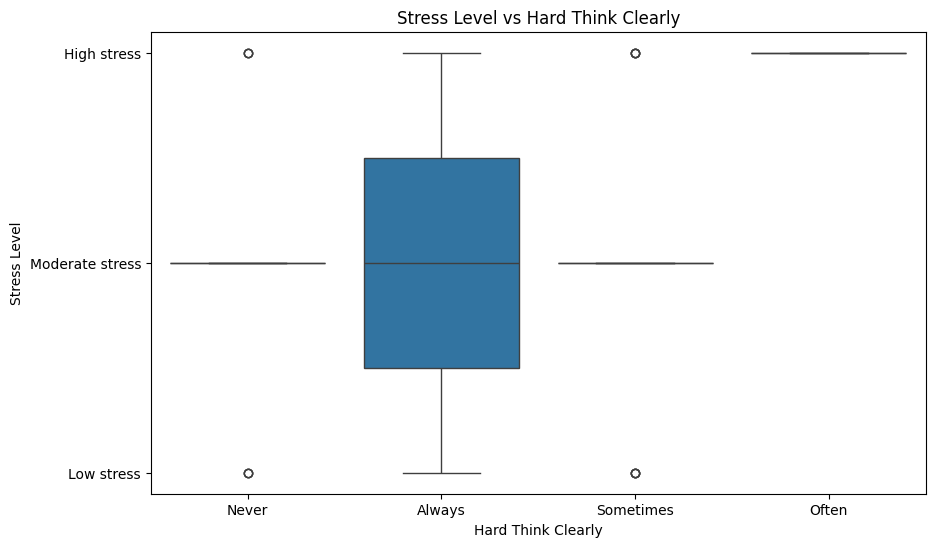

In [127]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='hard_think_clearly', y='stress_level')
plt.title('Stress Level vs Hard Think Clearly')
plt.xlabel('Hard Think Clearly')
plt.ylabel('Stress Level')
plt.show()

The assumption "Students who find it hard to think clearly in difficult situations tend to have higher stress level" is probably correct, but as some categories are spread and there are a lot of outliers, I wouldn't risk using it for prediction

#### often_rushed_work

"I often feel rushed in my work "

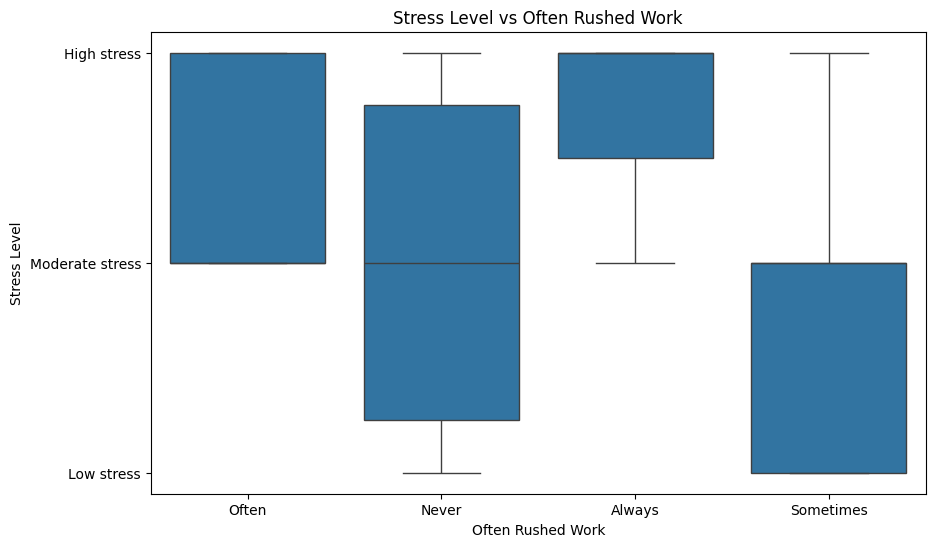

In [128]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='often_rushed_work', y='stress_level')
plt.title('Stress Level vs Often Rushed Work')
plt.xlabel('Often Rushed Work')
plt.ylabel('Stress Level')
plt.show()

The plot represents a linear-ish relation, even though the Never category ranges

#### not_sleeping_well

"I am not sleeping well"

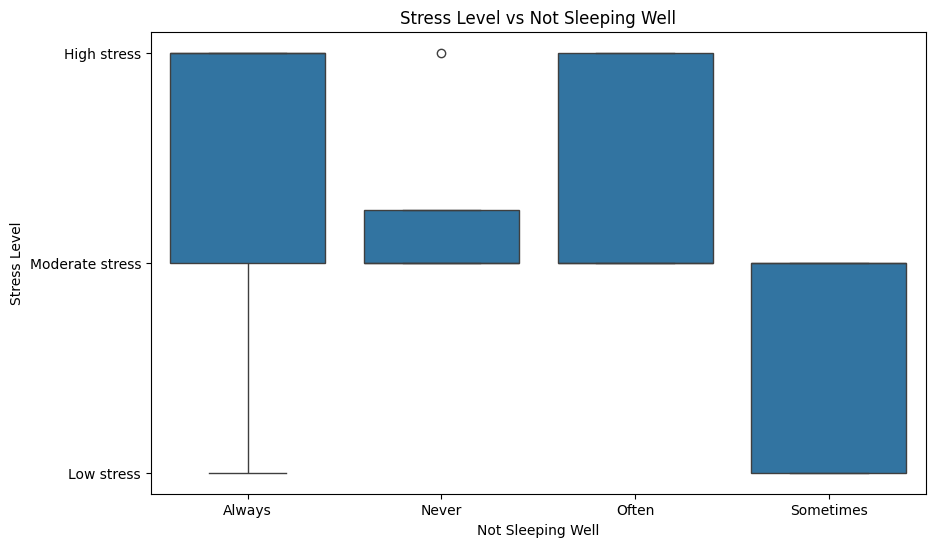

In [129]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='not_sleeping_well', y='stress_level')
plt.title('Stress Level vs Not Sleeping Well')
plt.xlabel('Not Sleeping Well')
plt.ylabel('Stress Level')
plt.show()

not_sleeping_well feature does not show a strong relation, but the categories range in a relatively solid way

#### sensitive_noise

I am sensitive to noise

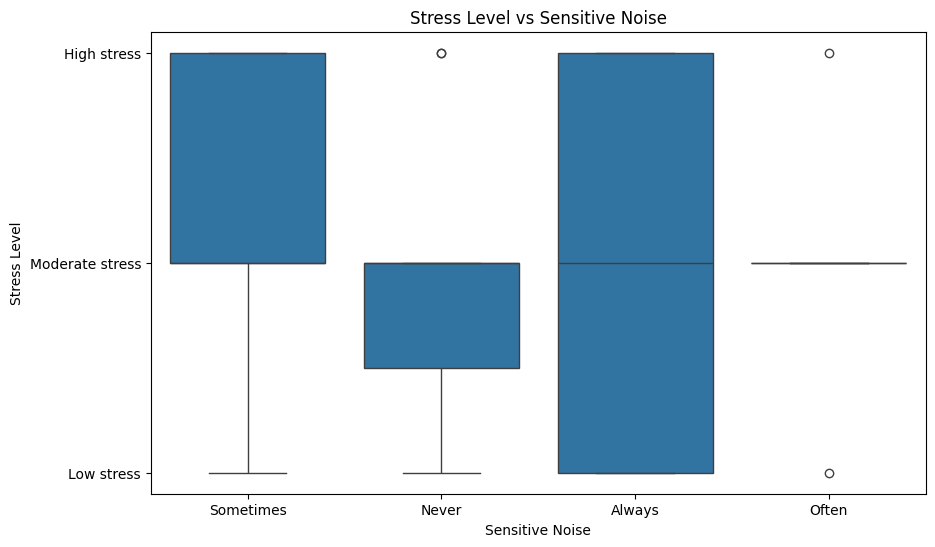

In [130]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='sensitive_noise', y='stress_level')
plt.title('Stress Level vs Sensitive Noise')
plt.xlabel('Sensitive Noise')
plt.ylabel('Stress Level')
plt.show()

The frequencies are messy so I wouldn't risk using them for prediction

#### find_criticism_difficult

"I find criticism difficult and I don't deal with it well"

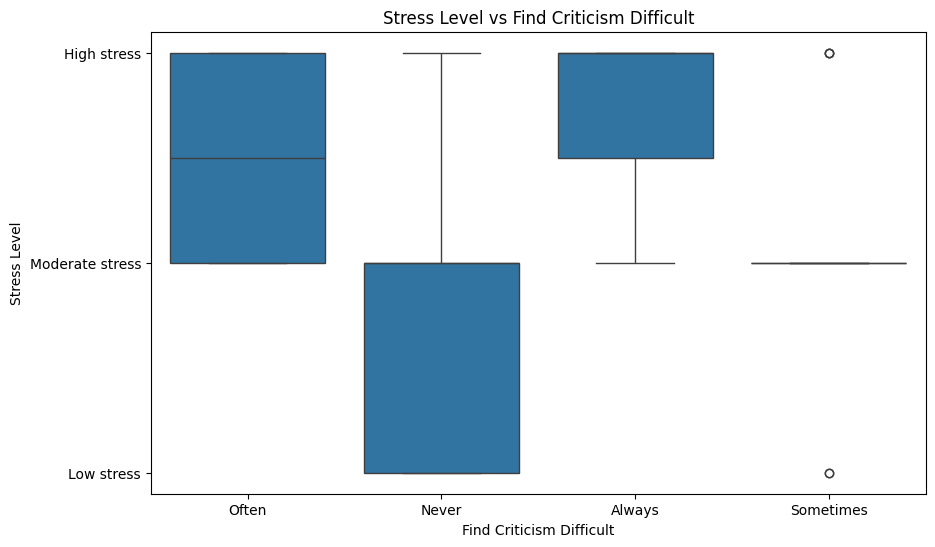

In [131]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='find_criticism_difficult', y='stress_level')
plt.title('Stress Level vs Find Criticism Difficult')
plt.xlabel('Find Criticism Difficult')
plt.ylabel('Stress Level')
plt.show()

the categories are structured in a solid way, judging from IQR

#### panic_attacks

"I often have panic attacks"

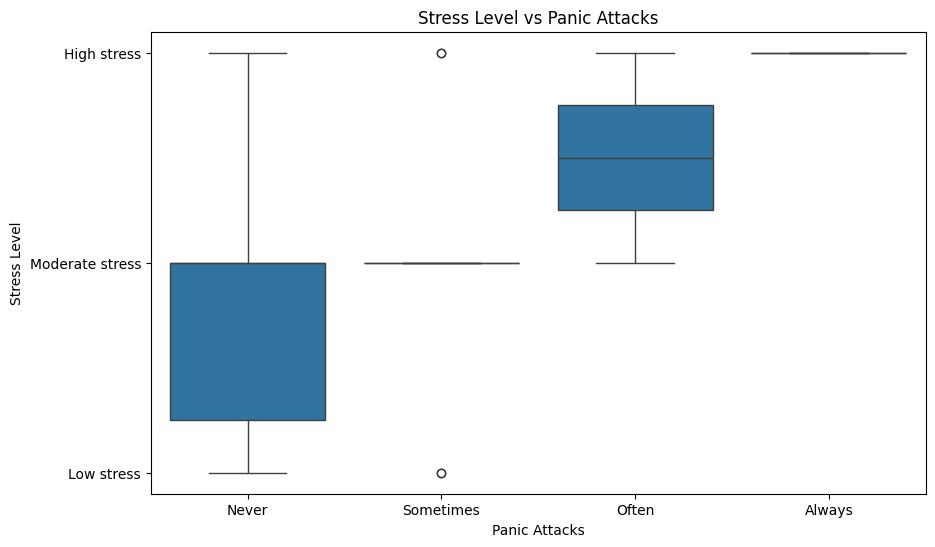

In [132]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='panic_attacks', y='stress_level')
plt.title('Stress Level vs Panic Attacks')
plt.xlabel('Panic Attacks')
plt.ylabel('Stress Level')
plt.show()

The plot represents a solid structure in the categories

#### stomachaches

I have stomachaches and/or intestinal problems

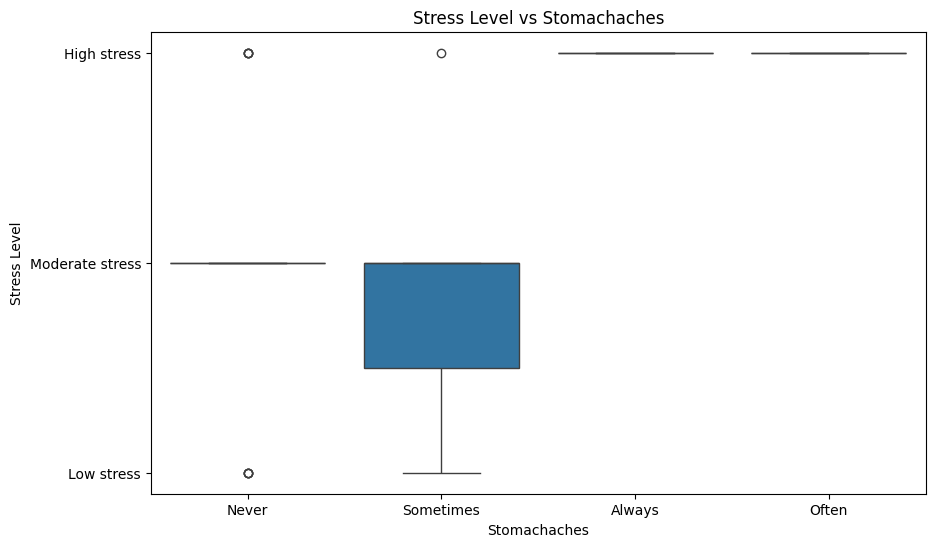

In [133]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='stomachaches', y='stress_level')
plt.title('Stress Level vs Stomachaches')
plt.xlabel('Stomachaches')
plt.ylabel('Stress Level')
plt.show()

The structure of the categories is what I would expect from the asked question

### Life events

#### moved_house

Has a student moved their house in the past 6 month?

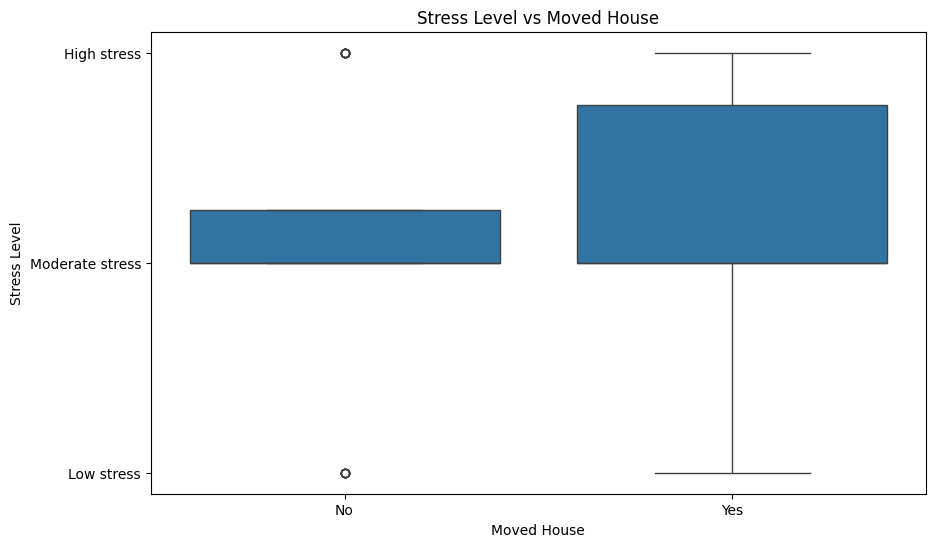

In [134]:
# moved_house,changes_lifestyle,financial_problems,sexual_problems,fellow_people_sick,experienced_injury,separated_family,experienced_death
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='moved_house', y='stress_level')
plt.title('Stress Level vs Moved House')
plt.xlabel('Moved House')
plt.ylabel('Stress Level')
plt.show()

Students who have recently moved their house have a higher stress level, but it is probably not root cause

#### changes_lifestyle

Has a student had any changes in their lifestyle recently?

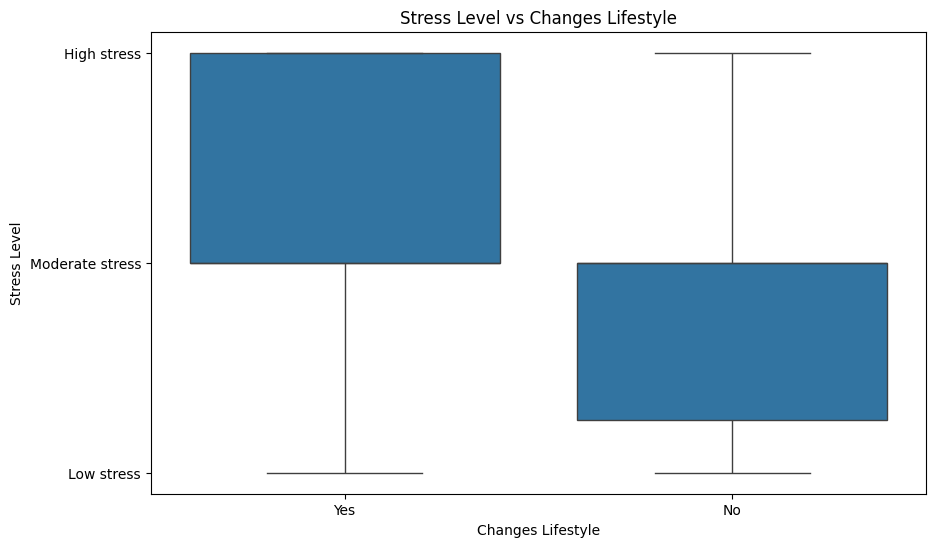

In [135]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='changes_lifestyle', y='stress_level')
plt.title('Stress Level vs Changes Lifestyle')
plt.xlabel('Changes Lifestyle')
plt.ylabel('Stress Level')
plt.show()

Students who have experienced major changes in their lifestyle have higher stress levels

#### financial_problems

Has a student had any financial problems lately?

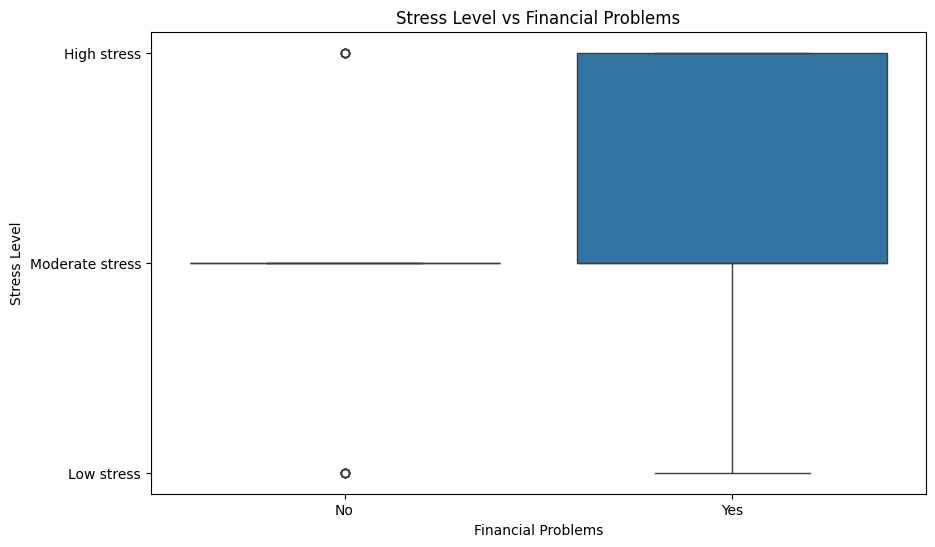

In [136]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='financial_problems', y='stress_level')
plt.title('Stress Level vs Financial Problems')
plt.xlabel('Financial Problems')
plt.ylabel('Stress Level')
plt.show()

Students who have experienced (or are still experiencing) financial problems tend to have higher stress levels

#### sexual_problems

Has a student had any sexual problems lately?

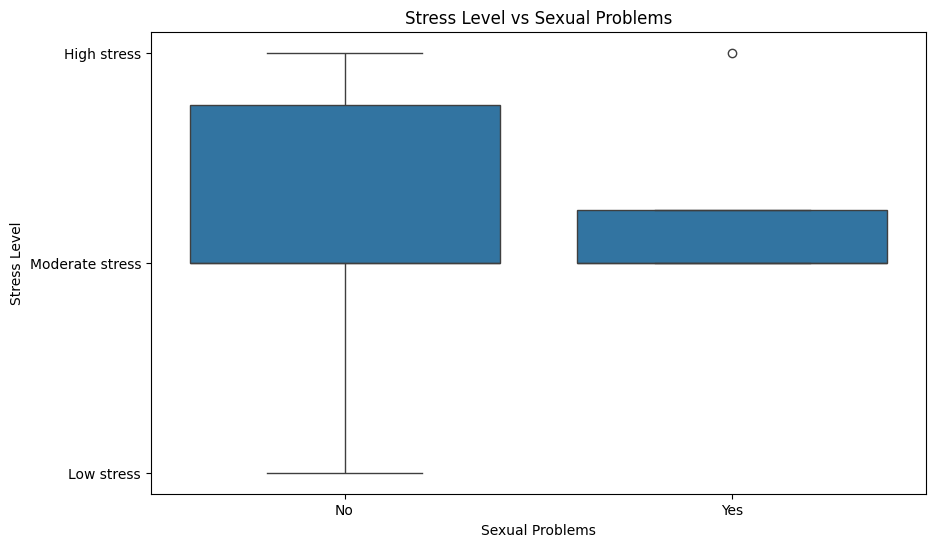

In [137]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='sexual_problems', y='stress_level')
plt.title('Stress Level vs Sexual Problems')
plt.xlabel('Sexual Problems')
plt.ylabel('Stress Level')
plt.show()

What is surprising, students who do not have sexual problems experience more stress than those who do have them. This topic needs closer investigation.

#### fellow_people_sick

Has any of a student's fellow people been sick (family member or relative) lately?

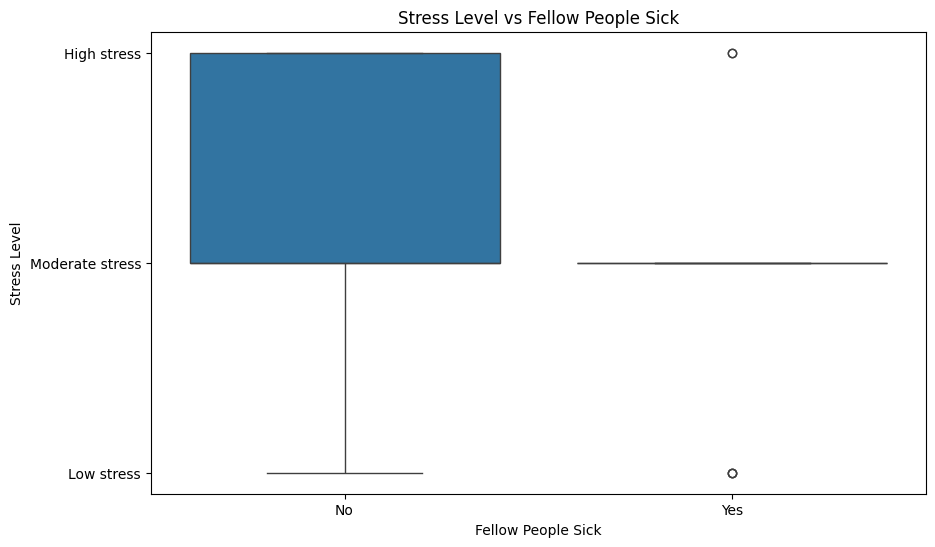

In [138]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='fellow_people_sick', y='stress_level')
plt.title('Stress Level vs Fellow People Sick')
plt.xlabel('Fellow People Sick')
plt.ylabel('Stress Level')
plt.show()

The plot shows that students who did not experience fellow people being sick have high stress level, which is weird

#### experienced_injury

Has a student experienced any injury or sickness lately?

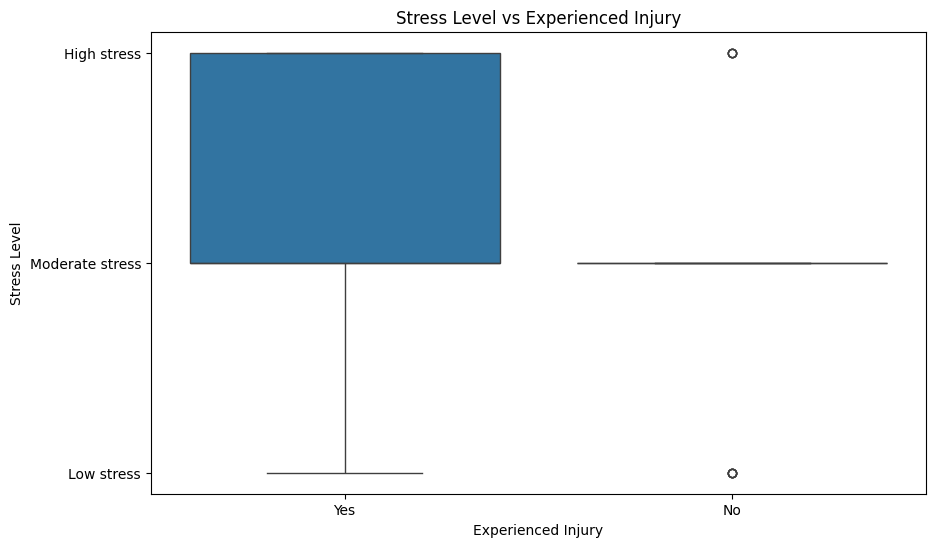

In [139]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='experienced_injury', y='stress_level')
plt.title('Stress Level vs Experienced Injury')
plt.xlabel('Experienced Injury')
plt.ylabel('Stress Level')
plt.show()

Students who have experienced injuries have higher stress level

#### separated_family

Has a student been separated from their family/partner?

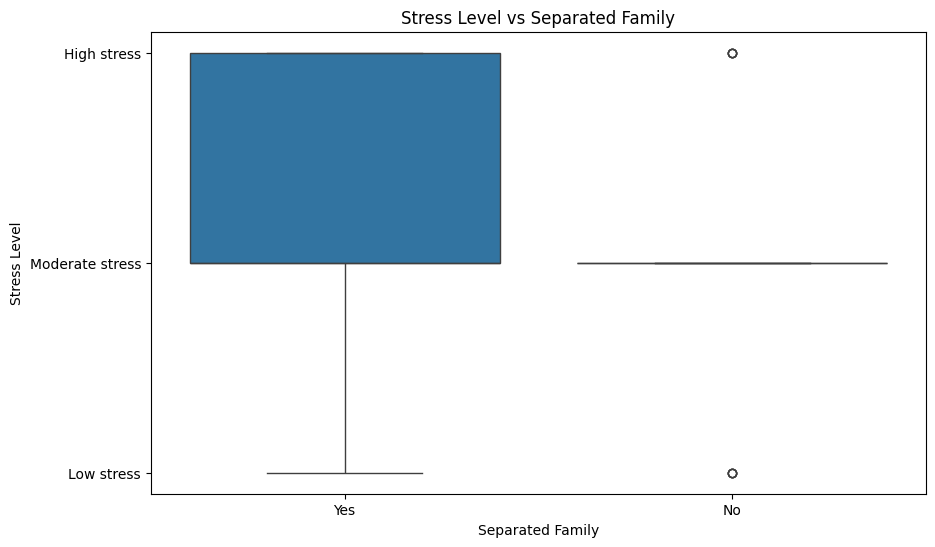

In [140]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='separated_family', y='stress_level')
plt.title('Stress Level vs Separated Family')
plt.xlabel('Separated Family')
plt.ylabel('Stress Level')
plt.show()

Students who for some reason have been separated from their family have high stress level

#### experienced_death

Has a student experience a death of their fellow person (close relative, partner, friend)?

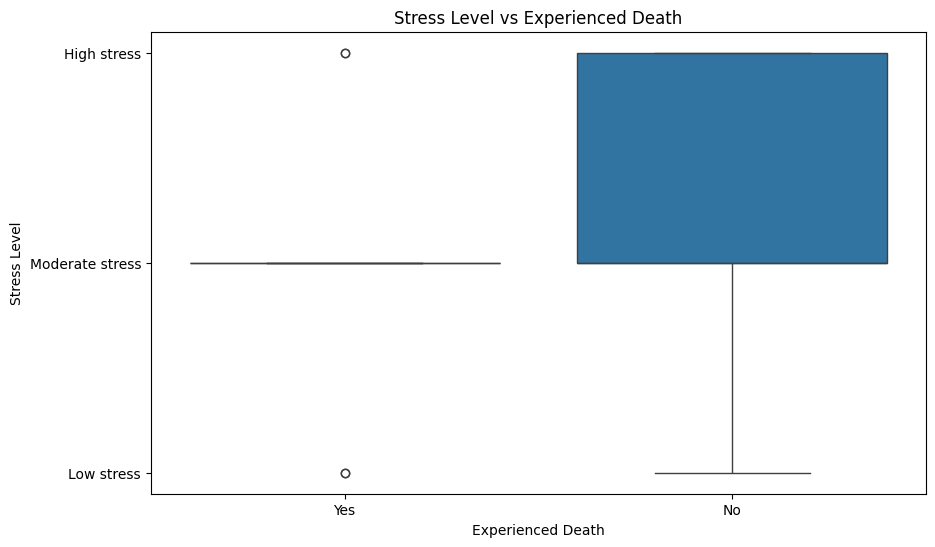

In [141]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=student_stress, x='experienced_death', y='stress_level')
plt.title('Stress Level vs Experienced Death')
plt.xlabel('Experienced Death')
plt.ylabel('Stress Level')
plt.show()

Again, a weird plot representing that students who did not experience death of their fellow people have higher stress level

## Data Preprocessing

In [142]:
unique_pss = student_stress['upset_academic_affairs'].unique()
print(unique_pss)

unique_stress_resistance = student_stress['never_satisfied_achievements'].unique()
print(unique_stress_resistance)

unique_life_events = student_stress['moved_house'].unique()
print(unique_stress_resistance)

['Very often' 'Sometimes' 'Fairly often' 'Almost never']
['Always' 'Never' 'Often' 'Sometimes']
['Always' 'Never' 'Often' 'Sometimes']


In [143]:
fontys_features = ["time_studying", "career_pursue", "part_time_job", "time_sleep", "diet", "time_physical_activities", "upset_academic_affairs", "unable_control_academic_affairs", "nervous_academic_pressure", "unable_cope_academic_activities", "confident_handle_academic_problems", "things_going_on_way", "control_irritations_academic_affairs", "academic_performance_top", "angered_bad_performance", "academic_difficulties_piling_up", "never_satisfied_achievements", "quickly_irritated_people", "future_gloomy", "quickly_impatient", "smoke_too_much", "hard_think_clearly", "often_rushed_work", "not_sleeping_well", "sensitive_noise", "find_criticism_difficult", "panic_attacks", "stomachaches", "moved_house", "changes_lifestyle", "financial_problems", "sexual_problems", "fellow_people_sick", "experienced_injury", "separated_family", "experienced_death"]
general_questions = ["time_studying", "career_pursue", "part_time_job", "time-sleep", "diet", "time-physical-activities"]
pss = ["upset_academic_affairs", "unable_control_academic_affairs", "nervous_academic_pressure", "unable_cope_academic_activities", "confident_handle_academic_problems", "things_going_on_way", "control_irritations_academic_affairs", "academic_performance_top", "angered_bad_performance", "academic_difficulties_piling_up"]
stress_resistance = ["never_satisfied_achievements", "quickly_irritated_people", "future_gloomy", "quickly_impatient", "smoke_too_much", "hard_think_clearly", "I often feel rushed in my work", "not_sleeping_well", "sensitive_noise", "find_criticism_difficult", "I often have panic attacks"]
life_events = ["stomachaches", "moved_house", "changes_lifestyle", "financial_problems", "sexual_problems", "fellow_people_sick", "experienced_injury", "separated_family", "experienced_death"]
target = ["stress_level"]

# general_questions preprocessing
student_stress["career_pursue"] = student_stress["career_pursue"].str.replace("%","")
student_stress["part_time_job"] = student_stress["part_time_job"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["diet"] = student_stress["diet"].map({'Unhealthy': 0, 'Average': 1, 'Healthy': 2}).astype(int)

# pss (percieved stress scale) preprocessing
student_stress["upset_academic_affairs"] = student_stress["upset_academic_affairs"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["unable_control_academic_affairs"] = student_stress["unable_control_academic_affairs"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["nervous_academic_pressure"] = student_stress["nervous_academic_pressure"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["unable_cope_academic_activities"] = student_stress["unable_cope_academic_activities"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["confident_handle_academic_problems"] = student_stress["confident_handle_academic_problems"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["things_going_on_way"] = student_stress["things_going_on_way"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["control_irritations_academic_affairs"] = student_stress["control_irritations_academic_affairs"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["academic_performance_top"] = student_stress["academic_performance_top"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["angered_bad_performance"] = student_stress["angered_bad_performance"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
student_stress["academic_difficulties_piling_up"] = student_stress["academic_difficulties_piling_up"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)

# stress_resistance preprocessing
student_stress["never_satisfied_achievements"] = student_stress["never_satisfied_achievements"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["quickly_irritated_people"] = student_stress["quickly_irritated_people"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["future_gloomy"] = student_stress["future_gloomy"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["quickly_impatient"] = student_stress["quickly_impatient"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["smoke_too_much"] = student_stress["smoke_too_much"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["hard_think_clearly"] = student_stress["hard_think_clearly"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["often_rushed_work"] = student_stress["often_rushed_work"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["not_sleeping_well"] = student_stress["not_sleeping_well"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["sensitive_noise"] = student_stress["sensitive_noise"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["find_criticism_difficult"] = student_stress["find_criticism_difficult"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["panic_attacks"] = student_stress["panic_attacks"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
student_stress["stomachaches"] = student_stress["stomachaches"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)

# life_events preprocessing
student_stress["moved_house"] = student_stress["moved_house"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["changes_lifestyle"] = student_stress["changes_lifestyle"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["financial_problems"] = student_stress["financial_problems"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["sexual_problems"] = student_stress["sexual_problems"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["fellow_people_sick"] = student_stress["fellow_people_sick"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["experienced_injury"] = student_stress["experienced_injury"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["separated_family"] = student_stress["separated_family"].map({'No': 0, 'Yes': 1}).astype(int)
student_stress["experienced_death"] = student_stress["experienced_death"].map({'No': 0, 'Yes': 1}).astype(int)

student_stress["stress_level"] = student_stress["stress_level"].map({'Low stress': 0, 'Moderate stress': 1, 'High stress': 2}).astype(int)

student_stress.sample(5)

,time_studying,career_pursue,part_time_job,time_sleep,diet,time_physical_activities,upset_academic_affairs,unable_control_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,...,stomachaches,moved_house,changes_lifestyle,financial_problems,sexual_problems,fellow_people_sick,experienced_injury,separated_family,experienced_death,stress_level
29,5.0,100,0,7.0,2,1.5,2,1,4,1,...,0,0,0,0,0,1,1,0,1,1
34,8.0,100,1,7.0,1,1.0,2,1,1,2,...,0,0,1,0,0,0,1,0,1,2
14,3.0,100,1,5.0,0,0.5,3,3,3,3,...,2,0,0,1,0,0,1,0,0,2
6,4.0,75,0,8.0,1,1.0,3,2,2,2,...,1,0,1,0,0,0,0,1,0,0
17,3.0,75,1,7.0,2,1.0,2,3,3,2,...,1,1,1,0,1,0,0,0,0,1


As durring the provisioning part I have found some features that have either weird or low relation with the target variable I will remove them

In [144]:
student_stress = student_stress.drop(columns=["time_studying", "career_pursue", "diet", "unable_control_academic_affairs", "confident_handle_academic_problems", "control_irritations_academic_affairs", "hard_think_clearly", "sensitive_noise", "stomachaches", "sexual_problems", "experienced_death"])
student_stress.sample(5)

,part_time_job,time_sleep,time_physical_activities,upset_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,things_going_on_way,academic_performance_top,angered_bad_performance,academic_difficulties_piling_up,...,not_sleeping_well,find_criticism_difficult,panic_attacks,moved_house,changes_lifestyle,financial_problems,fellow_people_sick,experienced_injury,separated_family,stress_level
15,1,5.0,0.0,3,2,1,1,2,2,2,...,3,0,0,1,0,1,1,1,1,0
37,1,7.0,0.0,2,2,2,2,2,2,2,...,1,0,0,1,0,0,0,0,0,0
24,0,7.0,2.0,3,4,2,1,1,0,1,...,2,0,1,0,1,0,1,1,1,1
18,1,5.0,4.0,2,3,0,3,2,2,0,...,3,1,0,0,0,0,1,1,1,1
0,1,6.0,2.0,4,3,3,2,1,1,3,...,3,2,0,0,1,0,0,1,1,2


The next step is to check the correlation matrix of the features that are left

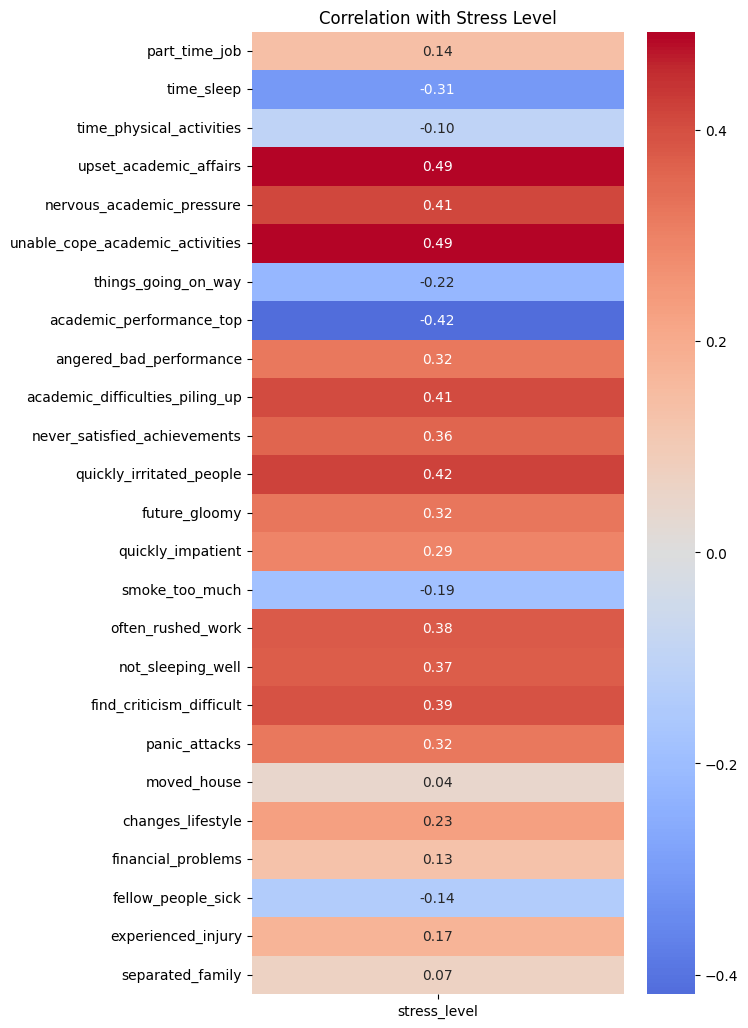

In [145]:
correlation_matrix = student_stress.corr()
stress_corr = correlation_matrix[['stress_level']].drop('stress_level')
plt.figure(figsize=(6, len(stress_corr) * 0.5)) 
sns.heatmap(stress_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation with Stress Level')
plt.show()

As midway of data provisioning i found out that the relation is not exactly classified as linear, I will change the method to spearman as it is better for ordinal data. the way it works is it ranks the data (assigns 0 to “Almost never”, 1 to “Sometimes”, etc.) and calculates the correlation of these ranks, not the raw values.

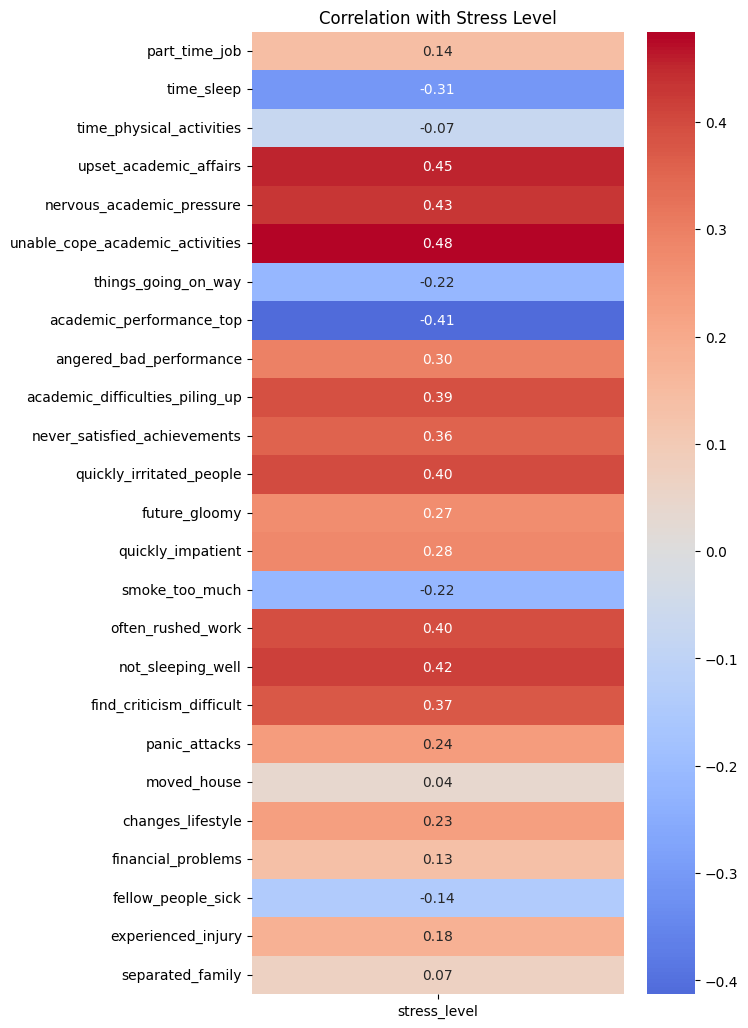

In [146]:
correlation_matrix = student_stress.corr(method='spearman')
stress_corr = correlation_matrix[['stress_level']].drop('stress_level')
plt.figure(figsize=(6, len(stress_corr) * 0.5)) 
sns.heatmap(stress_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation with Stress Level')
plt.show()

As some other features have low relation, I will remove them as well

In [147]:
student_stress = student_stress.drop(columns=["time_physical_activities", "moved_house", "fellow_people_sick"])
student_stress.sample(5)

,part_time_job,time_sleep,upset_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,things_going_on_way,academic_performance_top,angered_bad_performance,academic_difficulties_piling_up,never_satisfied_achievements,...,smoke_too_much,often_rushed_work,not_sleeping_well,find_criticism_difficult,panic_attacks,changes_lifestyle,financial_problems,experienced_injury,separated_family,stress_level
15,1,5.0,3,2,1,1,2,2,2,2,...,3,1,3,0,0,0,1,1,1,0
12,1,8.5,2,2,2,2,3,1,1,2,...,0,2,1,1,1,0,0,0,0,1
24,0,7.0,3,4,2,1,1,0,1,2,...,0,3,2,0,1,1,0,1,1,1
13,0,6.5,2,2,1,3,3,1,2,1,...,2,1,1,1,0,0,0,0,0,0
3,1,4.0,4,4,4,0,0,3,4,2,...,3,3,3,3,1,0,0,0,1,2


In [148]:
student_stress.to_csv('survey/fontys-stress-cleaned.csv', index=False)

What I have learned from my previous iteration is that models usually perform better with balanced data. For this purpose I will create several datasets for training different models on imbalanced and balanced data to see the difference

In [149]:
scaler = StandardScaler()
ros = RandomOverSampler(sampling_strategy='not majority')

# default dataset
X_student_stress = student_stress[['part_time_job', 'time_sleep', 'upset_academic_affairs', 'nervous_academic_pressure', 'unable_cope_academic_activities', 'things_going_on_way', 'academic_performance_top', 'angered_bad_performance', 'academic_difficulties_piling_up', 'never_satisfied_achievements', 'quickly_irritated_people', 'future_gloomy', 'quickly_impatient', 'smoke_too_much', 'often_rushed_work', 'not_sleeping_well', 'find_criticism_difficult', 'panic_attacks', 'changes_lifestyle', 'financial_problems', 'experienced_injury', 'separated_family']]
y_student_stress = student_stress['stress_level']

# scaled dataset
X_student_stress_scaled = pd.DataFrame(scaler.fit_transform(X_student_stress), columns=X_student_stress.columns)

# balanced dataset
X_resampled, y_resampled = ros.fit_resample(student_stress.drop(columns=['stress_level']), student_stress['stress_level'])

balanced_df = pd.DataFrame(X_resampled, columns=student_stress.columns[:-1])
balanced_df['stress_level'] = y_resampled

X_balanced = balanced_df[['part_time_job', 'time_sleep', 'upset_academic_affairs', 'nervous_academic_pressure', 'unable_cope_academic_activities', 'things_going_on_way', 'academic_performance_top', 'angered_bad_performance', 'academic_difficulties_piling_up', 'never_satisfied_achievements', 'quickly_irritated_people', 'future_gloomy', 'quickly_impatient', 'smoke_too_much', 'often_rushed_work', 'not_sleeping_well', 'find_criticism_difficult', 'panic_attacks', 'changes_lifestyle', 'financial_problems', 'experienced_injury', 'separated_family']]
y_balanced = y_resampled

# balanced & scaled dataset
X_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X_balanced.columns)

### Train/Test split

One thing that would be nice to use is to set the random state, but I did not do that, to avoid the situation when I have a bad distribution of classes in the sets. Instead I am using 'stratify', to keep the proportion of each class in both train and test sets.

In [150]:
# for decision tree models
X_train, X_test, y_train, y_test = train_test_split(X_student_stress, y_student_stress, test_size=.2, stratify=y_student_stress)
print("There are in total", len(X_student_stress), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")    

X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=.2, stratify=y_balanced)
print("There are in total", len(X_balanced), "balanced observations, of which", len(X_balanced_train), "are now in the train set, and", len(X_balanced_test), "in the test set.")

# for knn, svc and clustering models (those relying on distance)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_balanced_train_scaled = scaler.transform(X_balanced_train)
X_balanced_test_scaled = scaler.transform(X_balanced_test)


There are in total 38 observations, of which 30 are now in the train set, and 8 in the test set.
There are in total 60 balanced observations, of which 48 are now in the train set, and 12 in the test set.


## Models

During the feedback session with Machine Learning teacher I was requested to test my data on different models, so I have chosen the most common models for classification problem: 
- K-Nearest Neighbors
- Agglomerative Clustering (to see how unsupervised learning technique works on my data)
- Support Vector Classifier
- Decision Tree Classifier
- Ordinal Regression/Classification

As a method of tuning I have chosen GridSearchCV, as it performs K-Fold cross validation on each possible combination of chosen hyperparameters. The thing I will evaluate such tuning is the mean_test_score.

### K-Nearest Neighbors

#### Default dataset

##### Model Tuning

In [151]:
parameters = {'n_neighbors': [1, 3, 5, 7, 9, 11]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_student_stress_scaled, y_student_stress)
sorted(clf.cv_results_)
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df[['params', 'mean_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='rank_test_score')
results_df

,params,mean_test_score,rank_test_score
1,{'n_neighbors': 3},0.550000,1
0,{'n_neighbors': 1},0.528571,2
2,{'n_neighbors': 5},0.528571,3
4,{'n_neighbors': 9},0.503571,4
3,{'n_neighbors': 7},0.478571,5
5,{'n_neighbors': 11},0.478571,5


Looking at the tuning results, it can be seen that the accuracy is relatively low - 55% on the best performing model.

##### Model & Evaluation

In [152]:
knn = KNeighborsClassifier(n_neighbors=3)   
knn.fit(X_train_scaled, y_train)
score = knn.score(X_test_scaled, y_test)
print("Accuracy:", score)

Accuracy: 0.5


The model performed at 50%, which is a relatively bad result.

In [153]:
predictions = knn.predict(X_test_scaled)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.75      0.60         4
           2       1.00      0.50      0.67         2

    accuracy                           0.50         8
   macro avg       0.50      0.42      0.42         8
weighted avg       0.50      0.50      0.47         8



As the classification report performs a separate prediction, the accuracy reached 100% (each class was correctly classified). This is probably related to the fact that the test set is small (only 8 samples), and the model might be overfitted.

#### Balanced dataset

##### Model Tuning

In [154]:
parameters = {'n_neighbors': [1, 3, 5, 7, 9, 11]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_balanced_scaled, y_balanced)
sorted(clf.cv_results_)
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df[['params', 'mean_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='rank_test_score')
results_df

,params,mean_test_score,rank_test_score
0,{'n_neighbors': 1},0.733333,1
1,{'n_neighbors': 3},0.700000,2
2,{'n_neighbors': 5},0.633333,3
4,{'n_neighbors': 9},0.633333,4
5,{'n_neighbors': 11},0.633333,4
3,{'n_neighbors': 7},0.533333,6


The K-Nearest Neighbors models performs better with the balanced data, the record with the best accuracy is 85% (with n_neighbors parameter of 1). As I consider that the model with this parameter might be overfittied, I will also check the model with parameters 3 and 5

##### Model & Evaluation

In [155]:
knn = KNeighborsClassifier(n_neighbors=1)   
knn.fit(X_balanced_train_scaled, y_balanced_train)
score = knn.score(X_balanced_test_scaled, y_balanced_test)
print("Accuracy:", score)

Accuracy: 0.9166666666666666


The models accuracy reached 83%, which  is better than with the default dataset

In [156]:
predictions = knn.predict(X_balanced_test_scaled)
report = classification_report(y_balanced_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



The model classified the classes of Low and High stress perfectly, but the Moderate stress label was missed with the other 2 labels

In [157]:
knn = KNeighborsClassifier(n_neighbors=3)   
knn.fit(X_balanced_train_scaled, y_balanced_train)
score = knn.score(X_balanced_test_scaled, y_balanced_test)
print("Accuracy:", score)

Accuracy: 0.8333333333333334


The model with parameter of the n_neighbors 3 has performed worse than the previous variant.

### Agglomerative Clustering

For both models (with default and balanced data), I have specified only n_clusters hyperparameter, as I know in advance how many classes I have, and I am tuning the hierarchical clustering to find these clusters 

#### Default dataset

In [158]:
agglom = AgglomerativeClustering(n_clusters=3, compute_distances=True) 
agglom.fit(X_student_stress_scaled)

print('Number of clusters: ', agglom.n_clusters_)

Number of clusters:  3


In [159]:
print(np.unique(agglom.labels_))

[0 1 2]


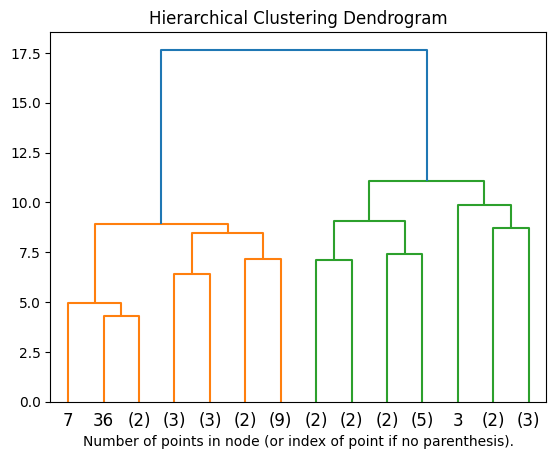

In [160]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglom, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [161]:
student_stress['cluster'] = agglom.labels_.astype(str)
student_stress['cluster'] = 'Cluster ' + student_stress['cluster']
student_stress.head(5)

,part_time_job,time_sleep,upset_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,things_going_on_way,academic_performance_top,angered_bad_performance,academic_difficulties_piling_up,never_satisfied_achievements,...,often_rushed_work,not_sleeping_well,find_criticism_difficult,panic_attacks,changes_lifestyle,financial_problems,experienced_injury,separated_family,stress_level,cluster
0,1,6.0,4,3,3,2,1,1,3,3,...,2,3,2,0,1,0,1,1,2,Cluster 2
1,1,5.0,2,4,2,3,3,2,4,3,...,2,3,0,0,1,0,0,1,1,Cluster 2
2,1,6.0,2,2,1,3,3,3,1,0,...,0,0,2,0,1,0,0,0,1,Cluster 1
3,1,4.0,4,4,4,0,0,3,4,2,...,3,3,3,1,0,0,0,1,2,Cluster 0
4,0,7.0,3,4,3,2,2,2,3,2,...,2,2,3,1,0,0,0,0,1,Cluster 2


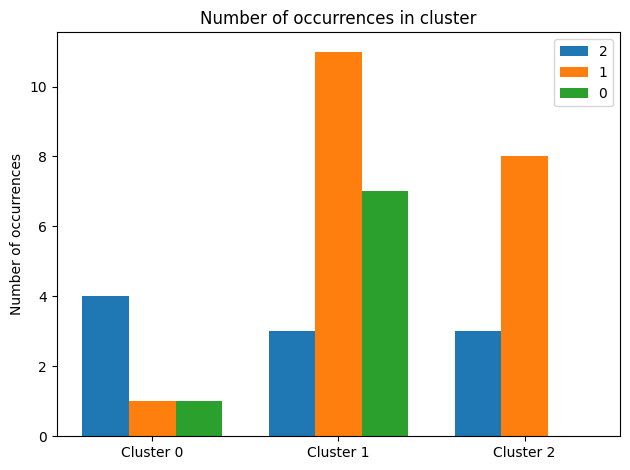

In [162]:
stress_levels = student_stress['stress_level'].unique()
clusters = student_stress['cluster'].unique()

clusters.sort()

x = np.arange(len(clusters))

width = 0.25

fig, ax = plt.subplots()
offset = -width
for lev in stress_levels:
    nr_occurrences = []
    for clus in clusters:
        nr = student_stress[(student_stress['stress_level']==lev) & (student_stress['cluster']==clus)]['cluster'].count()
        nr_occurrences.append(nr)
    rects = ax.bar(x + offset, nr_occurrences, width, label=lev)
    offset = offset + width

ax.set_ylabel('Number of occurrences')
ax.set_title('Number of occurrences in cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

fig.tight_layout()
plt.show()

In [163]:
print(student_stress['stress_level'].value_counts())
print(student_stress['cluster'].value_counts())

levels = student_stress['stress_level'].unique()
for level in levels:
    print('Number of samples per cluster for',level)
    print(student_stress[student_stress['stress_level']==level]['cluster'].value_counts())

stress_level
1    20
2    10
0     8
Name: count, dtype: int64
cluster
Cluster 1    21
Cluster 2    11
Cluster 0     6
Name: count, dtype: int64
Number of samples per cluster for 2
cluster
Cluster 0    4
Cluster 2    3
Cluster 1    3
Name: count, dtype: int64
Number of samples per cluster for 1
cluster
Cluster 1    11
Cluster 2     8
Cluster 0     1
Name: count, dtype: int64
Number of samples per cluster for 0
cluster
Cluster 1    7
Cluster 0    1
Name: count, dtype: int64


From the Number of occurrences in cluster plot, it can be seen that clustering on default dataset finds High and Moderate stress, but it mixes Moderate and Low stress a lot

One small step before coming to the next model, is to drop 'cluster' column

In [164]:
student_stress.drop(columns=['cluster'], inplace=True)
student_stress.head(5)

,part_time_job,time_sleep,upset_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,things_going_on_way,academic_performance_top,angered_bad_performance,academic_difficulties_piling_up,never_satisfied_achievements,...,smoke_too_much,often_rushed_work,not_sleeping_well,find_criticism_difficult,panic_attacks,changes_lifestyle,financial_problems,experienced_injury,separated_family,stress_level
0,1,6.0,4,3,3,2,1,1,3,3,...,0,2,3,2,0,1,0,1,1,2
1,1,5.0,2,4,2,3,3,2,4,3,...,0,2,3,0,0,1,0,0,1,1
2,1,6.0,2,2,1,3,3,3,1,0,...,1,0,0,2,0,1,0,0,0,1
3,1,4.0,4,4,4,0,0,3,4,2,...,3,3,3,3,1,0,0,0,1,2
4,0,7.0,3,4,3,2,2,2,3,2,...,0,2,2,3,1,0,0,0,0,1


#### Balanced dataset

In [165]:
agglom = AgglomerativeClustering(n_clusters=3, compute_distances=True) 
agglom.fit(X_balanced_scaled)

print('Number of clusters: ', agglom.n_clusters_)

Number of clusters:  3


In [166]:
print(np.unique(agglom.labels_))

[0 1 2]


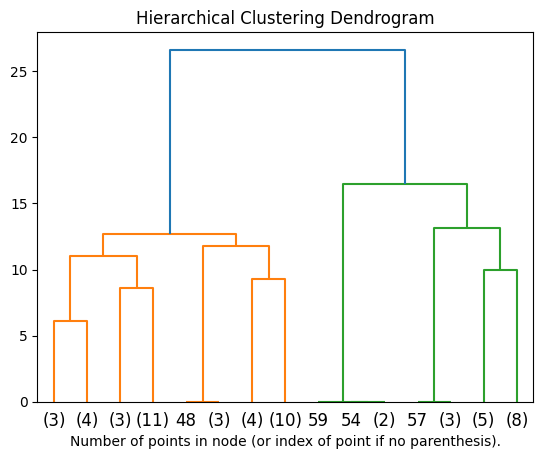

In [167]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglom, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [168]:
balanced_df['cluster'] = agglom.labels_.astype(str)
balanced_df['cluster'] = 'Cluster ' + balanced_df['cluster']
balanced_df.head(5)

,part_time_job,time_sleep,upset_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,things_going_on_way,academic_performance_top,angered_bad_performance,academic_difficulties_piling_up,never_satisfied_achievements,...,often_rushed_work,not_sleeping_well,find_criticism_difficult,panic_attacks,changes_lifestyle,financial_problems,experienced_injury,separated_family,stress_level,cluster
0,1,6.0,4,3,3,2,1,1,3,3,...,2,3,2,0,1,0,1,1,2,Cluster 0
1,1,5.0,2,4,2,3,3,2,4,3,...,2,3,0,0,1,0,0,1,1,Cluster 0
2,1,6.0,2,2,1,3,3,3,1,0,...,0,0,2,0,1,0,0,0,1,Cluster 1
3,1,4.0,4,4,4,0,0,3,4,2,...,3,3,3,1,0,0,0,1,2,Cluster 2
4,0,7.0,3,4,3,2,2,2,3,2,...,2,2,3,1,0,0,0,0,1,Cluster 0


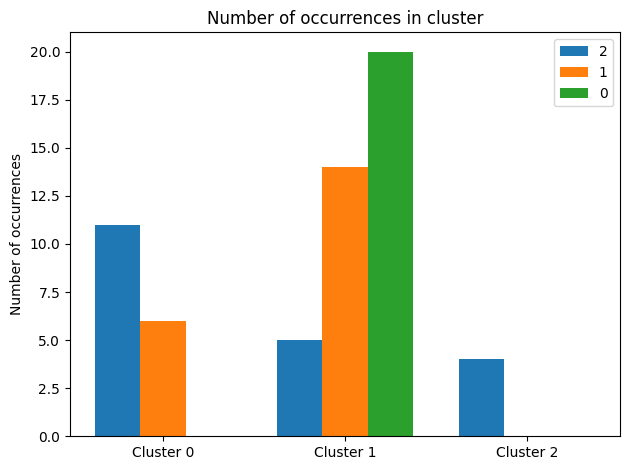

In [169]:
stress_levels = balanced_df['stress_level'].unique()
clusters = balanced_df['cluster'].unique()

clusters.sort()

x = np.arange(len(clusters))

width = 0.25

fig, ax = plt.subplots()
offset = -width
for lev in stress_levels:
    nr_occurrences = []
    for clus in clusters:
        nr = balanced_df[(balanced_df['stress_level']==lev) & (balanced_df['cluster']==clus)]['cluster'].count()
        nr_occurrences.append(nr)
    rects = ax.bar(x + offset, nr_occurrences, width, label=lev)
    offset = offset + width

ax.set_ylabel('Number of occurrences')
ax.set_title('Number of occurrences in cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

fig.tight_layout()
plt.show()

In [170]:
print(balanced_df['stress_level'].value_counts())
print(balanced_df['cluster'].value_counts())

levels = balanced_df['stress_level'].unique()
for level in levels:
    print('Number of samples per cluster for',level)
    print(balanced_df[balanced_df['stress_level']==level]['cluster'].value_counts())

stress_level
2    20
1    20
0    20
Name: count, dtype: int64
cluster
Cluster 1    39
Cluster 0    17
Cluster 2     4
Name: count, dtype: int64
Number of samples per cluster for 2
cluster
Cluster 0    11
Cluster 1     5
Cluster 2     4
Name: count, dtype: int64
Number of samples per cluster for 1
cluster
Cluster 1    14
Cluster 0     6
Name: count, dtype: int64
Number of samples per cluster for 0
cluster
Cluster 1    20
Name: count, dtype: int64


The situation is even worse than with the default data - almost all classes are mixed in Cluster 0, and the other clusters contain mostly High stress labels

### Support Vector Classifier

#### Default dataset

##### Model Tuning

In [171]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.5, 1, 2, 5, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_student_stress_scaled, y_student_stress)
sorted(clf.cv_results_)
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
results_df = results_df[['param_C', 'param_kernel', 'mean_test_score', 'rank_test_score']]
results_df

,param_C,param_kernel,mean_test_score,rank_test_score
4,1.0,rbf,0.657143,1
11,5.0,poly,0.632143,2
8,2.0,poly,0.607143,3
14,10.0,poly,0.607143,3
7,2.0,rbf,0.582143,5
5,1.0,poly,0.582143,5
10,5.0,rbf,0.557143,7
13,10.0,rbf,0.557143,7
2,0.5,poly,0.553571,9
1,0.5,rbf,0.528571,10


The model with parameters C: 1 / kernel: rbf shows the best results out of all - 66%. 

##### Model / Evaluation

In [172]:
svc = svm.SVC(C= 1, kernel='rbf')
svc.fit(X_train_scaled, y_train)
score = svc.score(X_test_scaled, y_test)
print("Accuracy:", score)

Accuracy: 0.625


The model performed at 50% accuracy with the test set, which is bad

In [173]:
predictions = svc.predict(X_test_scaled)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.57      1.00      0.73         4
           2       1.00      0.50      0.67         2

    accuracy                           0.62         8
   macro avg       0.52      0.50      0.46         8
weighted avg       0.54      0.62      0.53         8



c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

All classes were mixed with the Moderate stress class

#### Balanced dataset

##### Model Tuning

In [174]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.5, 1, 2, 5, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_balanced_train_scaled, y_balanced_train)
sorted(clf.cv_results_)
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
results_df = results_df[['param_C', 'param_kernel', 'mean_test_score', 'rank_test_score']]
results_df


,param_C,param_kernel,mean_test_score,rank_test_score
11,5.0,poly,0.788889,1
14,10.0,poly,0.768889,2
8,2.0,poly,0.766667,3
3,1.0,linear,0.751111,4
9,5.0,linear,0.751111,4
6,2.0,linear,0.751111,4
12,10.0,linear,0.751111,4
10,5.0,rbf,0.748889,8
13,10.0,rbf,0.748889,8
0,0.5,linear,0.733333,10


With the balanced data, the better parameters turned out to be C: 10, kernel: poly, with the accuracy of 77%

##### Model & Evaluation

In [175]:
svc = svm.SVC(C= 10, kernel='poly')
svc.fit(X_balanced_train_scaled, y_balanced_train)
score = svc.score(X_balanced_test_scaled, y_balanced_test)
print("Accuracy:", score)

Accuracy: 1.0


The model with the chosen parameters has performed at 83% accuracy, which is nice.

In [176]:
predictions = svc.predict(X_balanced_test_scaled)
report = classification_report(y_balanced_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



From the classification report it can be seen that the Moderate stress level was mixed with the other 2.

### Decision Tree

#### Default dataset

##### Model Tuning

In [177]:
parameters = {'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10, 20],'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtc = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(dtc, parameters, cv=5)
clf.fit(X_train, y_train)
sorted(clf.cv_results_)
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
results_imbalanced_df = results_df[['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'rank_test_score']]
print(results_imbalanced_df.head(10))

   param_max_depth  param_min_samples_split  mean_test_score  rank_test_score
10               3                        3         0.433333                1
11               3                        4         0.433333                1
9                3                        2         0.433333                1
12               3                        5         0.400000                4
29               5                        4         0.400000                4
28               5                        3         0.400000                4
38               6                        4         0.400000                4
37               6                        3         0.400000                4
36               6                        2         0.400000                4
27               5                        2         0.366667               10


The thing I have noticed during this and my last iteration is that the Decision Tree Classifier does not perform too good with my data. From the dataframe above it can be seen that the accuracy does not go higher than 50% which is bad.

##### Model & Evaluation & Inference

In [178]:
dtc = DecisionTreeClassifier(max_depth=5, min_samples_split=4)
dtc.fit(X_train, y_train)
score = dtc.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.375


The accuracy in the test set is 25% which is just funny

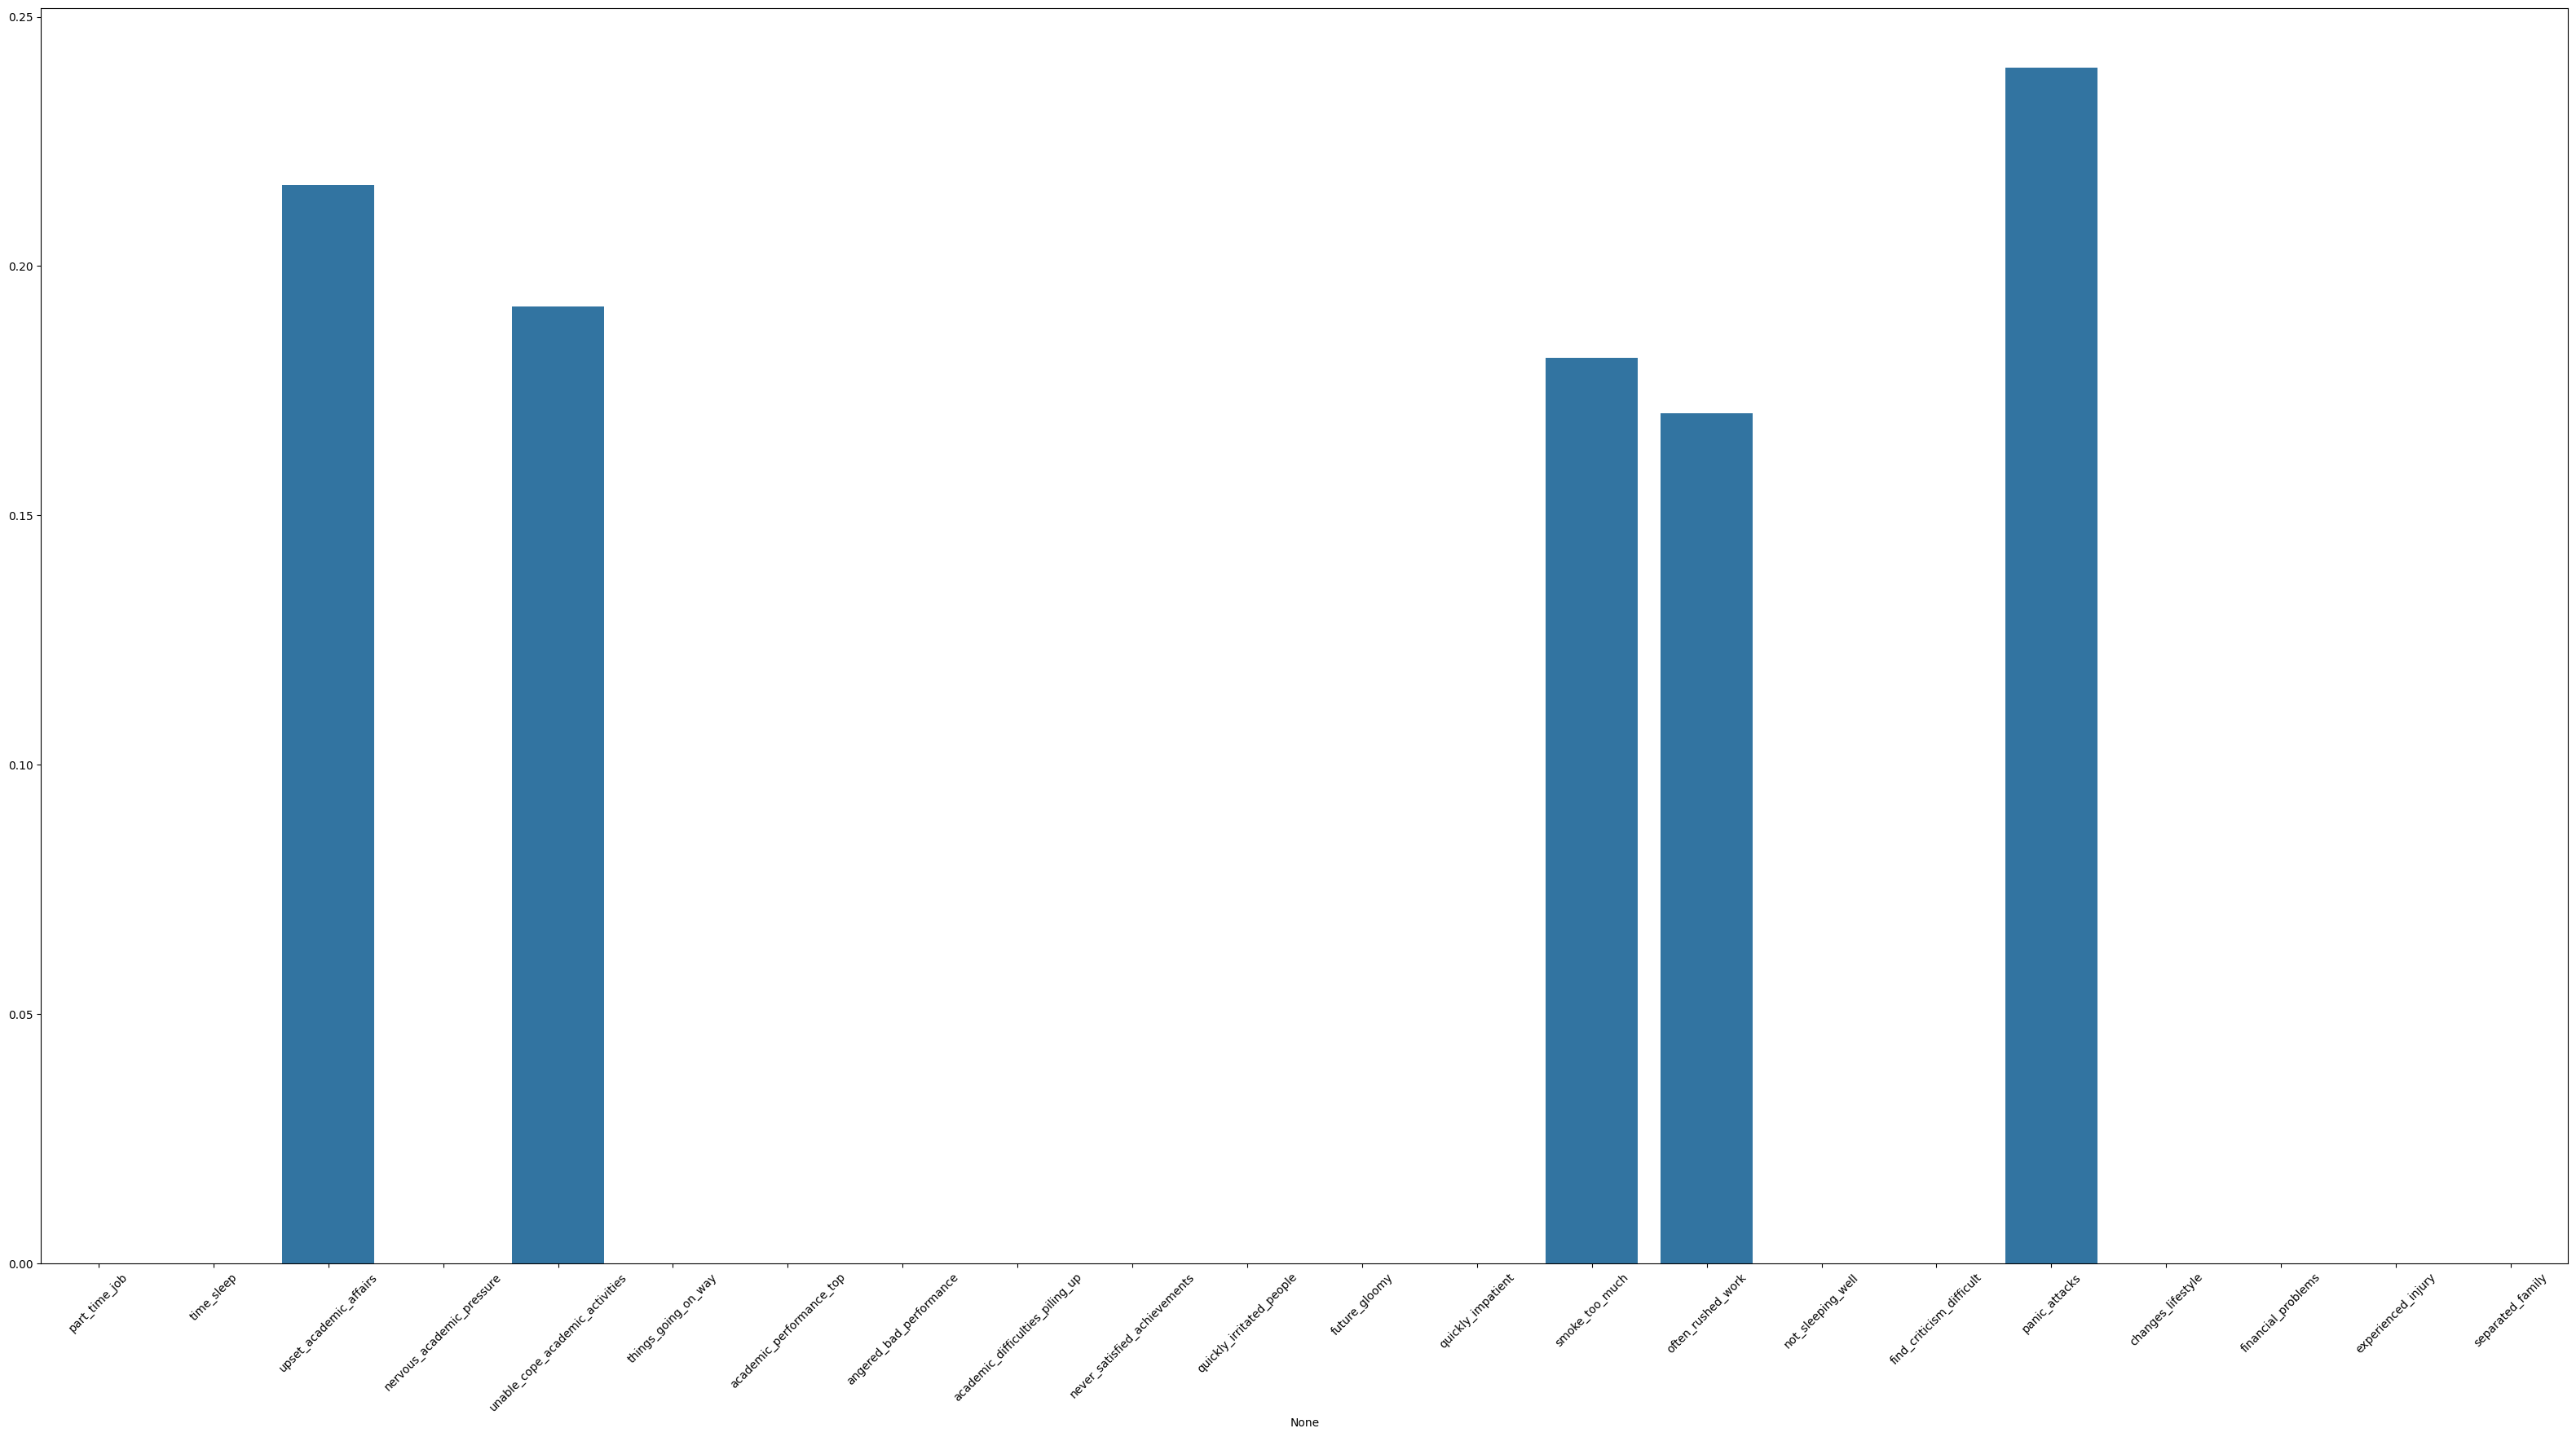

In [179]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=dtc.feature_importances_, x=X_student_stress.columns)
plt.xticks(rotation=45)
plt.show()

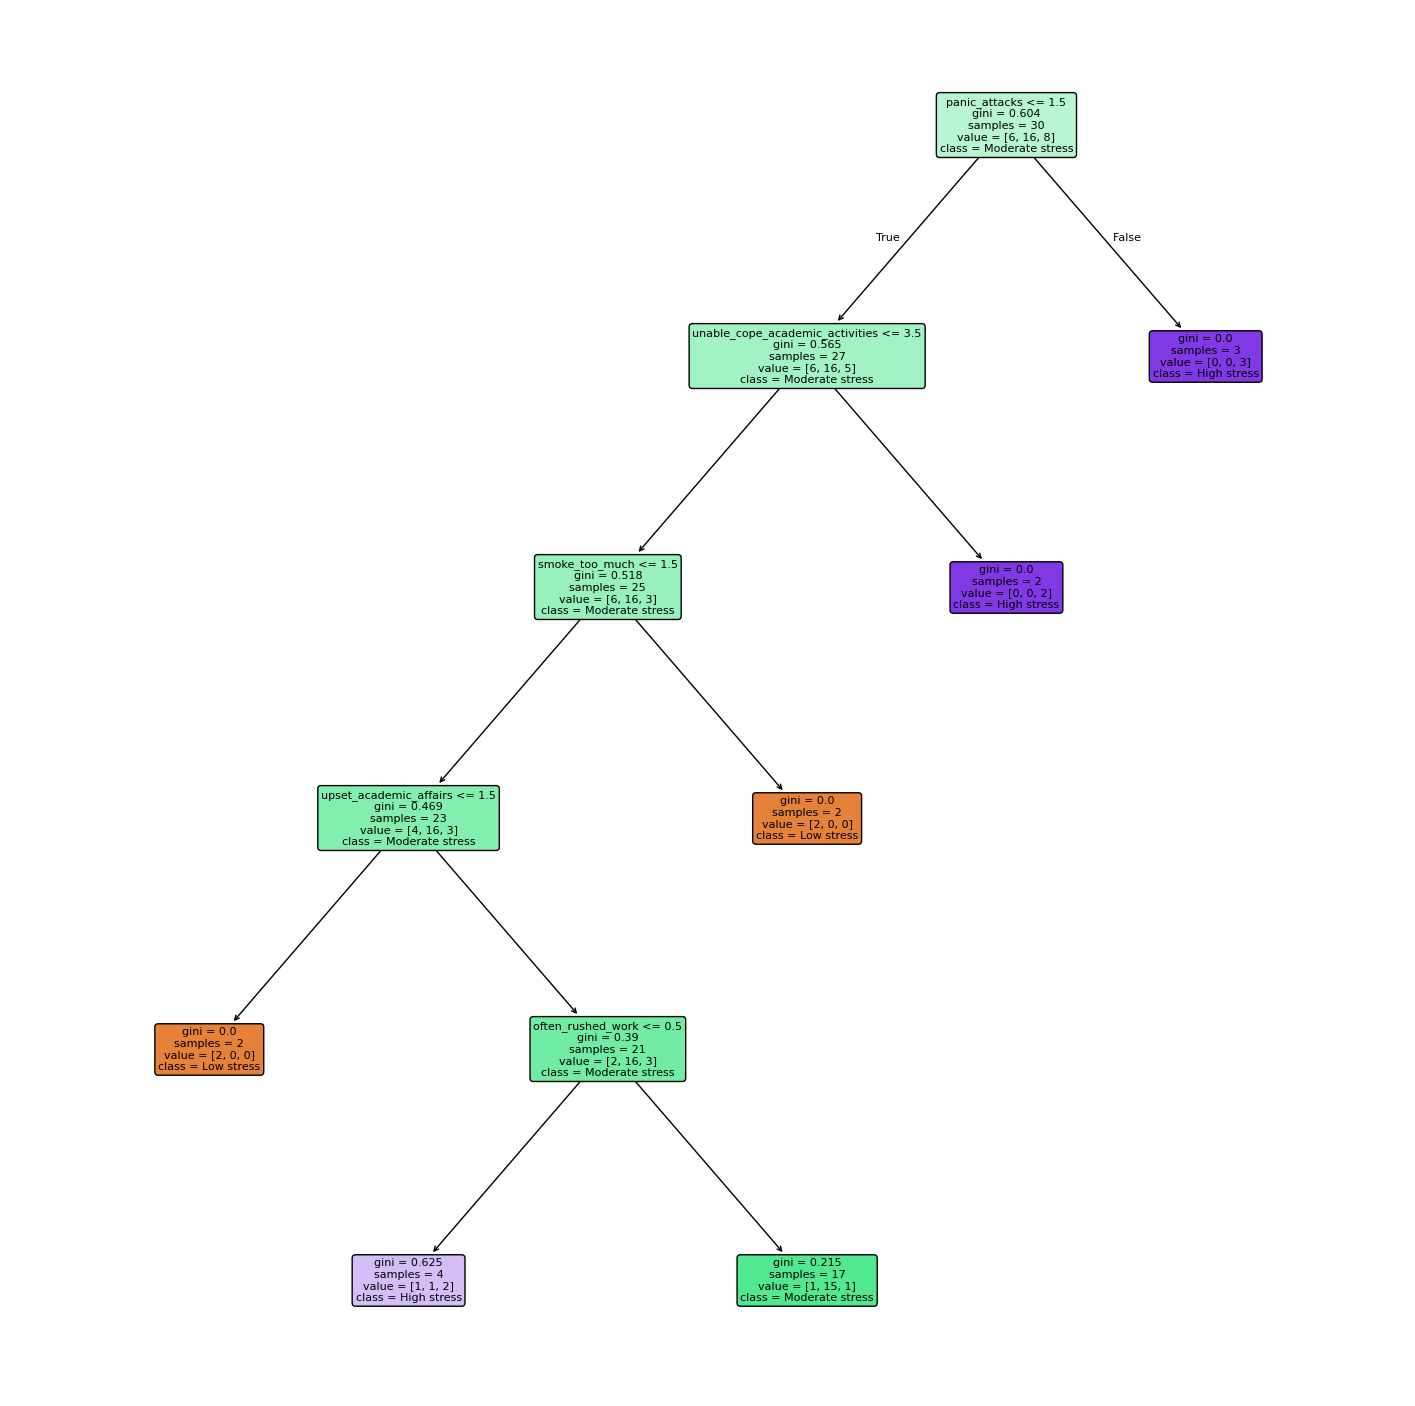

In [180]:
target_names = ["Low stress", "Moderate stress", "High stress"]
plt.figure(figsize=(18,18))
plot_tree(dtc, fontsize=8, feature_names=X_student_stress.columns, class_names=target_names, filled=True, rounded=True)
plt.show()

In [181]:
data = {'part_time_job': 0, 'time_sleep': 7, 'upset_academic_affairs': 4, 'nervous_academic_pressure': 4, 'unable_cope_academic_activities': 3, 'things_going_on_way': 2, 
        'academic_performance_top': 1, 'angered_bad_performance': 2, 'academic_difficulties_piling_up': 2, 'never_satisfied_achievements': 3, 'quickly_irritated_people': 1,
        'future_gloomy': 3, 'quickly_impatient': 2, 'smoke_too_much': 3, 'often_rushed_work': 3, 'not_sleeping_well': 3, 'find_criticism_difficult': 3,
        'panic_attacks': 3, 'changes_lifestyle': 2, 'financial_problems': 1, 'experienced_injury': 1, 'separated_family': 1}

X_inference = pd.DataFrame([data], columns=X_student_stress.columns)

prediction = dtc.predict_proba(X_inference)

result = pd.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

# feedback messages
feedback_map = {
    "part_time_job": "Managing a part-time job while studying can lead to stress. Try to ensure your workload remains manageable and doesn't affect your health or academics.",
    "time_sleep": "Getting enough quality sleep helps improve memory, focus, and emotional regulation. Aim for 7–9 hours of consistent rest.",
    "upset_academic_affairs": "Feeling upset about academic issues is normal. Reflect on the root causes and consider talking to a tutor or advisor.",
    "nervous_academic_pressure": "Academic pressure can trigger anxiety. Try breaking down tasks, practicing mindfulness, or speaking to a counselor if it feels overwhelming.",
    "unable_cope_academic_activities": "If you're finding it difficult to keep up, consider reassessing your commitments or speaking with your academic advisor for support.",
    "things_going_on_way": "When things are progressing well, take a moment to acknowledge your effort—it can boost confidence and motivation.",
    "academic_performance_top": "Maintaining top performance is impressive, but be careful not to burn out. Take breaks and celebrate small wins.",
    "angered_bad_performance": "It’s okay to feel frustrated. Use setbacks as learning opportunities and consider seeking academic support if needed.",
    "academic_difficulties_piling_up": "When challenges build up, it helps to prioritize and tackle tasks one step at a time. Don’t hesitate to ask for help.",
    "never_satisfied_achievements": "Striving for more is good, but it's also important to recognize your progress and give yourself credit.",
    "quickly_irritated_people": "If you're feeling irritable often, it may be a sign of stress or fatigue. Consider self-care strategies or relaxation exercises.",
    "future_gloomy": "Uncertainty about the future is common. Setting small, achievable goals can help you regain a sense of direction and control.",
    "quickly_impatient": "If you’re easily impatient, try breathing exercises or short breaks to stay centered when things feel frustrating.",
    "smoke_too_much": "Increased smoking may be a stress response. Exploring healthier outlets like exercise or hobbies might help reduce dependency.",
    "often_rushed_work": "Consistently rushing through work may affect quality. Try time-blocking your schedule to stay organized and reduce last-minute pressure.",
    "not_sleeping_well": "Poor sleep quality impacts concentration and mood. Establish a calming bedtime routine and limit screen use before bed.",
    "find_criticism_difficult": "Criticism can be tough, but it’s often a chance to grow. Try to see feedback as constructive, not personal.",
    "panic_attacks": "Experiencing panic attacks can be serious. Consider speaking with a counselor or healthcare professional for support.",
    "changes_lifestyle": "Lifestyle changes (diet, activity, routine) can significantly affect stress levels. Try to keep healthy habits consistent.",
    "financial_problems": "Financial worries are stressful. Look into student budgeting tools or speak with financial aid offices for guidance.",
    "experienced_injury": "Injuries can affect mental and physical well-being. Prioritize recovery and don’t hesitate to ask for academic accommodations.",
    "separated_family": "Being away from family can be emotionally hard. Regular communication or joining support communities can help ease feelings of isolation."
}

# decision path → used features
tree = dtc.tree_
features = X_inference.columns

# list of node's indices in the path of the decision
node_path = dtc.decision_path(X_inference).indices

# list of features used in the path of the decision (ignoring leaf nodes)
used_feats = {
    features[tree.feature[n]]
    for n in node_path
    if tree.feature[n] != _tree.TREE_UNDEFINED
}

print(result)
print("\nFeedback:")

# looking for intersection in used features and all feedback features
for f in used_feats & feedback_map.keys():
    print(f"- {feedback_map[f]}")

           Outcome  Probability
0       Low stress          0.0
1  Moderate stress          0.0
2      High stress          1.0

Feedback:
- Experiencing panic attacks can be serious. Consider speaking with a counselor or healthcare professional for support.


In the Inference I have used my own data (as if I was using the model myself), and the model identified me as a student with Moderate stress (which is not true). 

#### Balanced dataset

##### Model Tuning

In [182]:
parameters = {'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10, 20],'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtc = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(dtc, parameters, cv=5)
clf.fit(X_balanced_train, y_balanced_train)
sorted(clf.cv_results_)
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
results_df = results_df[['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'rank_test_score']]
print(results_df.head(10))

   param_max_depth  param_min_samples_split  mean_test_score  rank_test_score
27               5                        2         0.788889                1
0             None                        2         0.768889                2
10               3                        3         0.768889                2
9                3                        2         0.768889                2
18               4                        2         0.768889                2
22               4                        6         0.768889                2
19               4                        3         0.768889                2
24               4                        8         0.768889                2
23               4                        7         0.768889                2
63               9                        2         0.768889                2


With the balanced dataset the model is performing much better, the model with the best accuracy is 77% 

##### Model & Evaluation & Inference

In [183]:
dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=4)
dtc.fit(X_balanced_train, y_balanced_train)
score = dtc.score(X_balanced_test, y_balanced_test)
print("Accuracy:", score)

Accuracy: 0.6666666666666666


On the test set, the model has performed at 83% accuracy which is better than it used to be

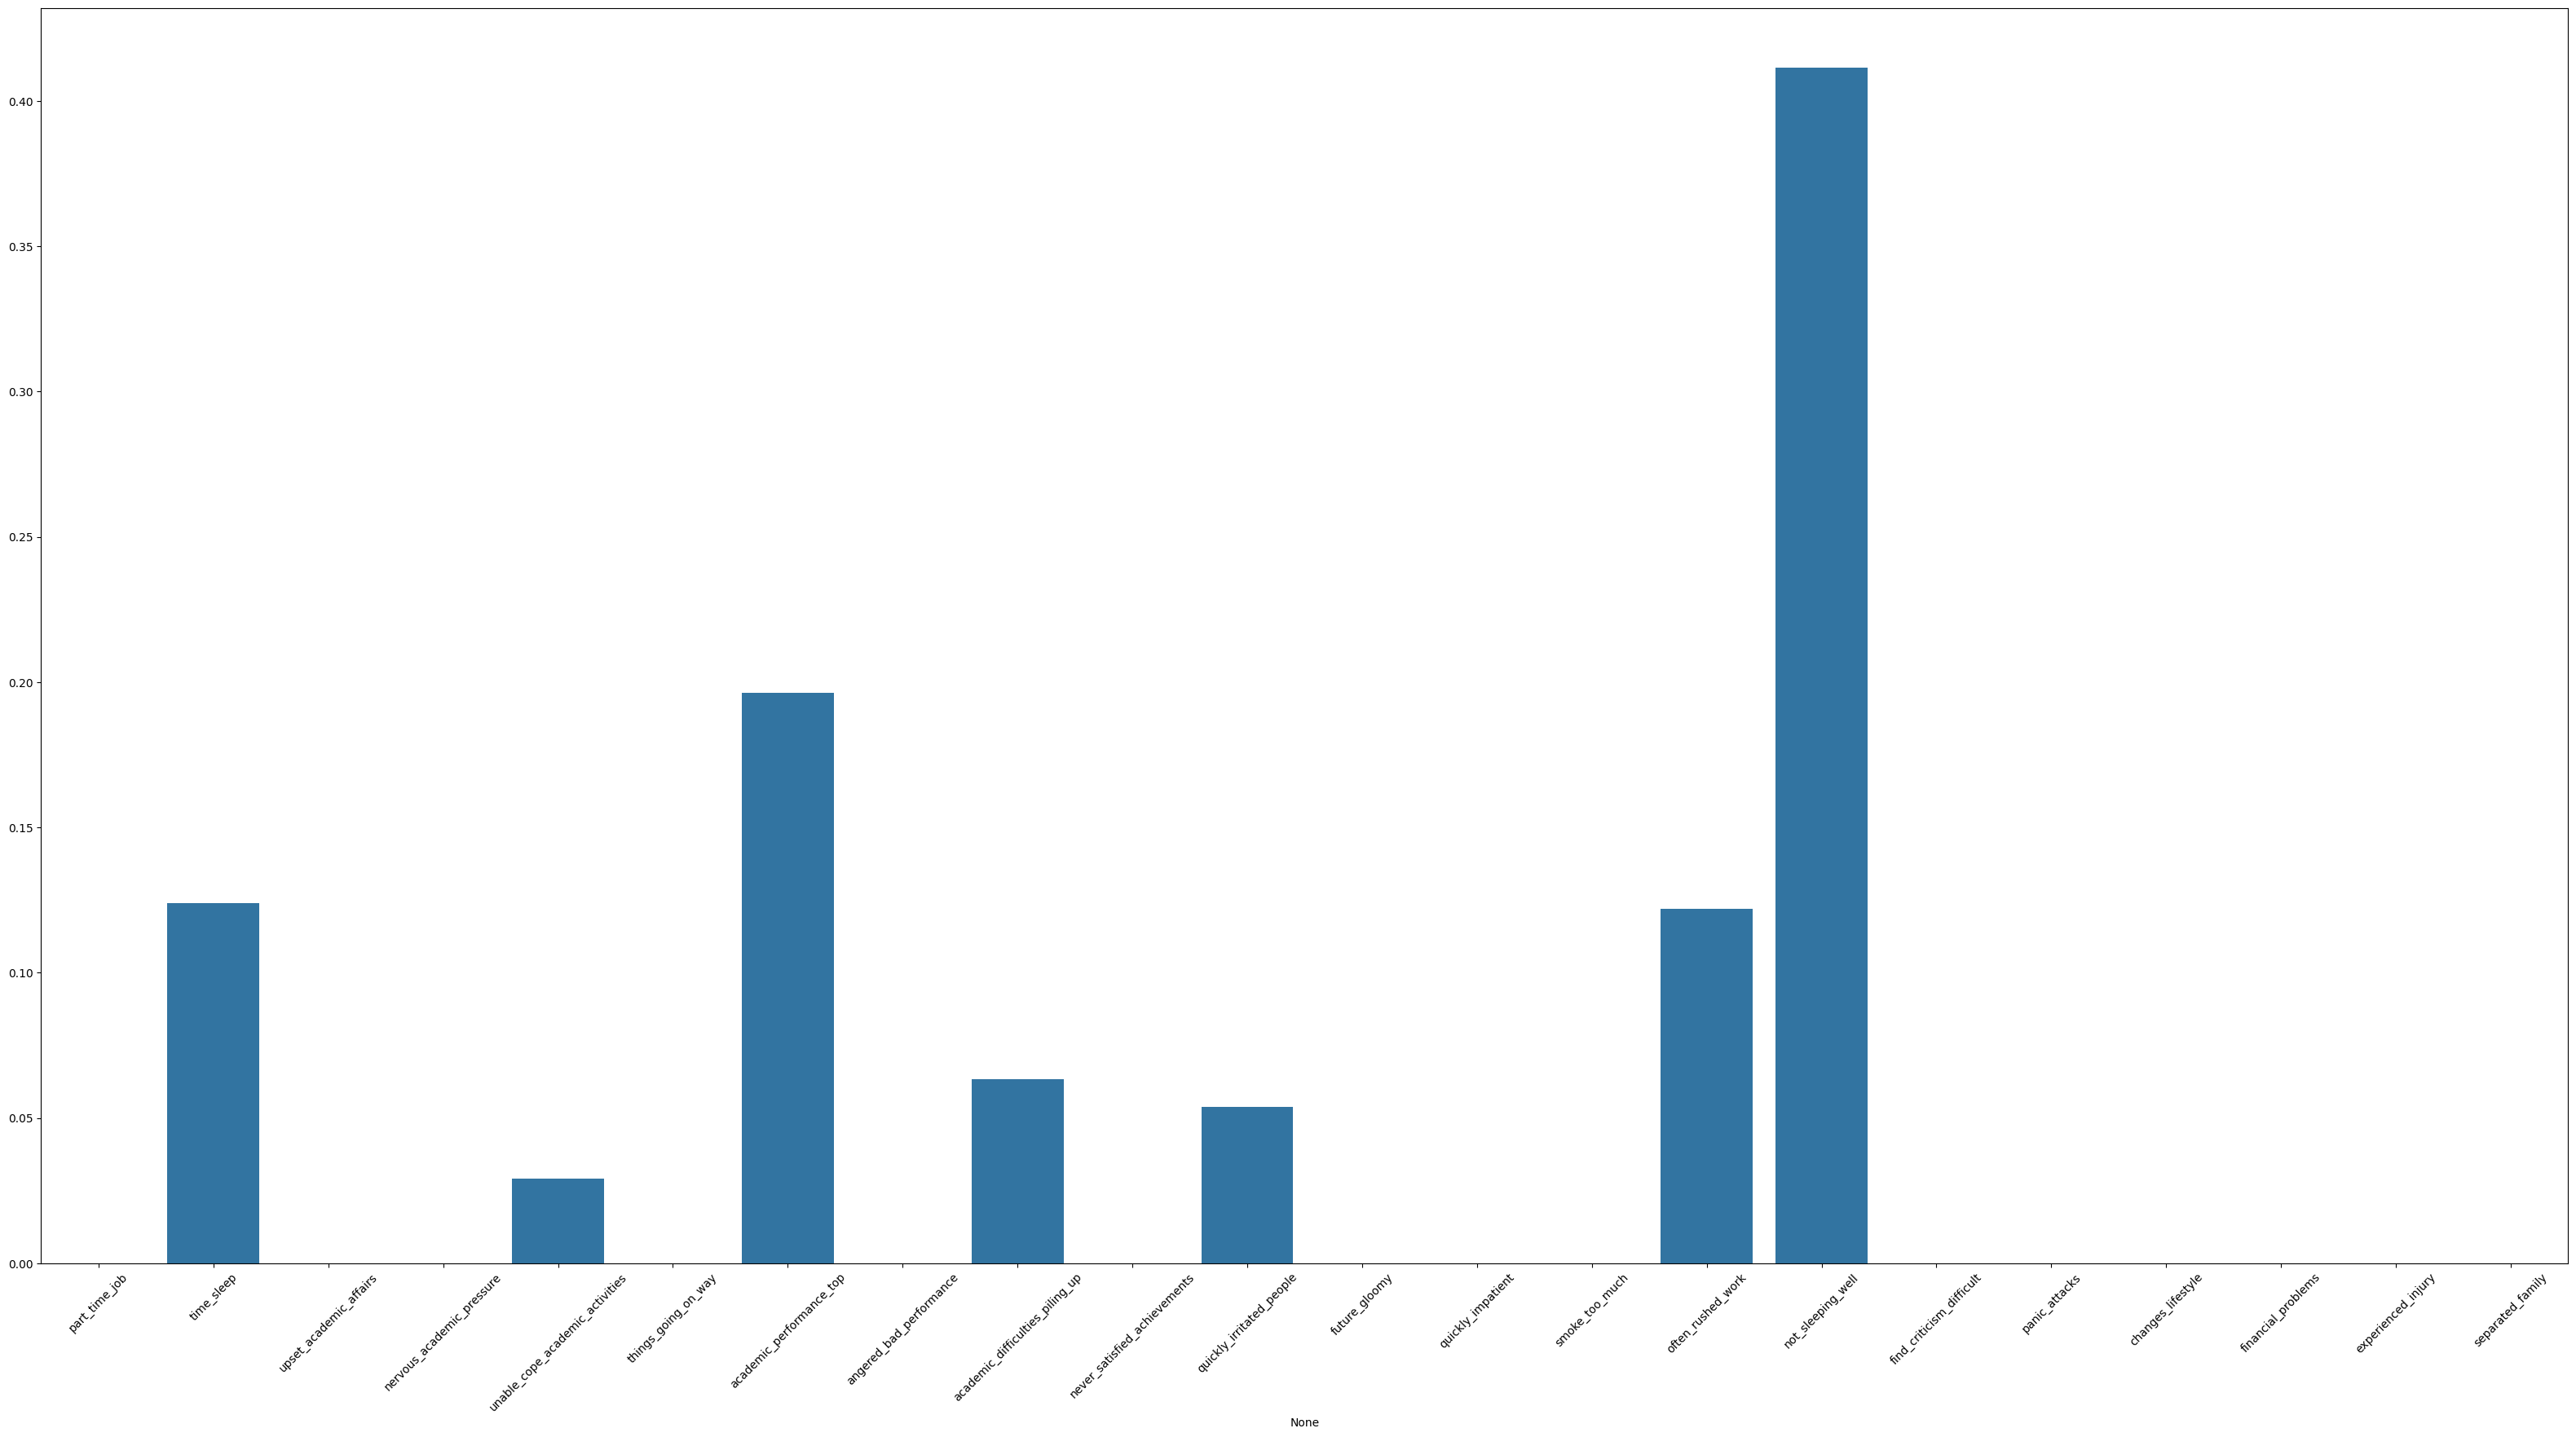

In [184]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=dtc.feature_importances_, x=X_balanced.columns)
plt.xticks(rotation=45)
plt.show()

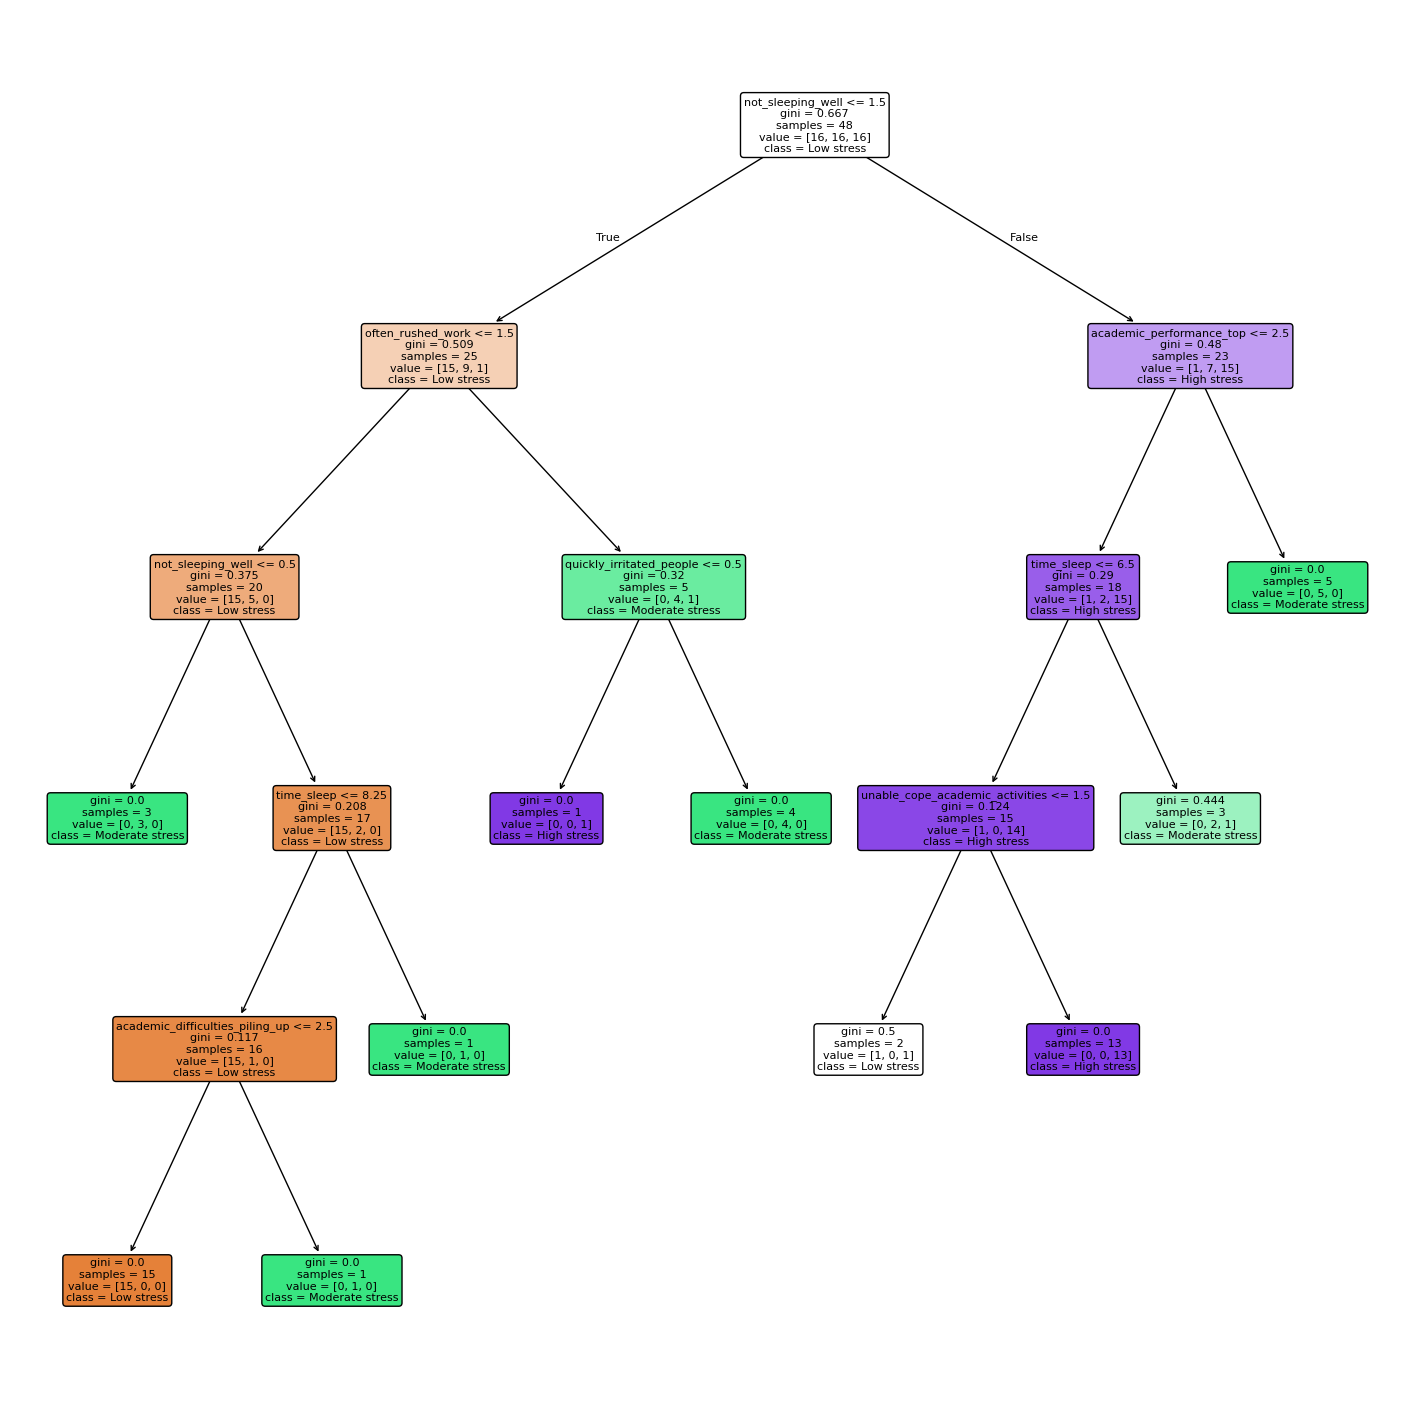

In [185]:
target_names = ["Low stress", "Moderate stress", "High stress"]
plt.figure(figsize=(18,18))
plot_tree(dtc, fontsize=8, feature_names=X_balanced.columns, class_names=target_names, filled=True, rounded=True)
plt.show()

In [186]:
data = {'part_time_job': 0, 'time_sleep': 7, 'upset_academic_affairs': 4, 'nervous_academic_pressure': 4, 'unable_cope_academic_activities': 3, 'things_going_on_way': 2, 
        'academic_performance_top': 1, 'angered_bad_performance': 2, 'academic_difficulties_piling_up': 2, 'never_satisfied_achievements': 3, 'quickly_irritated_people': 1,
        'future_gloomy': 3, 'quickly_impatient': 2, 'smoke_too_much': 3, 'often_rushed_work': 3, 'not_sleeping_well': 3, 'find_criticism_difficult': 3,
        'panic_attacks': 3, 'changes_lifestyle': 2, 'financial_problems': 1, 'experienced_injury': 1, 'separated_family': 1}

X_inference = pd.DataFrame([data], columns=X_student_stress.columns)

prediction = dtc.predict_proba(X_inference)

result = pd.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

# feedback messages
feedback_map = {
    "part_time_job": "Managing a part-time job while studying can lead to stress. Try to ensure your workload remains manageable and doesn't affect your health or academics.",
    "time_sleep": "Getting enough quality sleep helps improve memory, focus, and emotional regulation. Aim for 7–9 hours of consistent rest.",
    "upset_academic_affairs": "Feeling upset about academic issues is normal. Reflect on the root causes and consider talking to a tutor or advisor.",
    "nervous_academic_pressure": "Academic pressure can trigger anxiety. Try breaking down tasks, practicing mindfulness, or speaking to a counselor if it feels overwhelming.",
    "unable_cope_academic_activities": "If you're finding it difficult to keep up, consider reassessing your commitments or speaking with your academic advisor for support.",
    "things_going_on_way": "When things are progressing well, take a moment to acknowledge your effort—it can boost confidence and motivation.",
    "academic_performance_top": "Maintaining top performance is impressive, but be careful not to burn out. Take breaks and celebrate small wins.",
    "angered_bad_performance": "It’s okay to feel frustrated. Use setbacks as learning opportunities and consider seeking academic support if needed.",
    "academic_difficulties_piling_up": "When challenges build up, it helps to prioritize and tackle tasks one step at a time. Don’t hesitate to ask for help.",
    "never_satisfied_achievements": "Striving for more is good, but it's also important to recognize your progress and give yourself credit.",
    "quickly_irritated_people": "If you're feeling irritable often, it may be a sign of stress or fatigue. Consider self-care strategies or relaxation exercises.",
    "future_gloomy": "Uncertainty about the future is common. Setting small, achievable goals can help you regain a sense of direction and control.",
    "quickly_impatient": "If you’re easily impatient, try breathing exercises or short breaks to stay centered when things feel frustrating.",
    "smoke_too_much": "Increased smoking may be a stress response. Exploring healthier outlets like exercise or hobbies might help reduce dependency.",
    "often_rushed_work": "Consistently rushing through work may affect quality. Try time-blocking your schedule to stay organized and reduce last-minute pressure.",
    "not_sleeping_well": "Poor sleep quality impacts concentration and mood. Establish a calming bedtime routine and limit screen use before bed.",
    "find_criticism_difficult": "Criticism can be tough, but it’s often a chance to grow. Try to see feedback as constructive, not personal.",
    "panic_attacks": "Experiencing panic attacks can be serious. Consider speaking with a counselor or healthcare professional for support.",
    "changes_lifestyle": "Lifestyle changes (diet, activity, routine) can significantly affect stress levels. Try to keep healthy habits consistent.",
    "financial_problems": "Financial worries are stressful. Look into student budgeting tools or speak with financial aid offices for guidance.",
    "experienced_injury": "Injuries can affect mental and physical well-being. Prioritize recovery and don’t hesitate to ask for academic accommodations.",
    "separated_family": "Being away from family can be emotionally hard. Regular communication or joining support communities can help ease feelings of isolation."
}

# decision path → used features
tree = dtc.tree_
features = X_inference.columns

# list of node's indices in the path of the decision
node_path = dtc.decision_path(X_inference).indices

# list of features used in the path of the decision (ignoring leaf nodes)
used_feats = {
    features[tree.feature[n]]
    for n in node_path
    if tree.feature[n] != _tree.TREE_UNDEFINED
}

print(result)
print("\nFeedback:")

# looking for intersection in used features and all feedback features
for f in used_feats & feedback_map.keys():
    print(f"- {feedback_map[f]}")

           Outcome  Probability
0       Low stress     0.000000
1  Moderate stress     0.666667
2      High stress     0.333333

Feedback:
- Poor sleep quality impacts concentration and mood. Establish a calming bedtime routine and limit screen use before bed.
- Getting enough quality sleep helps improve memory, focus, and emotional regulation. Aim for 7–9 hours of consistent rest.
- Maintaining top performance is impressive, but be careful not to burn out. Take breaks and celebrate small wins.


The model identified me as a studdent with High stress level (which is true), and gave a reasonable feedback

### Ordinal Regression

As (unfortunately only mid-way of the data analysis) I have discovered that ordinal (ordered categorical) data needs specific techniques in terms of analysis, I have also decided to try to use one thing that was not a part of the semester curriculum and that is not present in the sklearn library - Ordinal Classification/Regression (both names can be used). Such model is mostly used in problems that are intermediate between classification and regression.

There are 2 categories of Ordinal Regression:
- Ordered Logit Model (logistic distribution)
- Ordered Probit Model (normal distribution)

The idea of the Ordinal Regression, is that it creates a latent scale, looks how features shift a record on this scale, makes threshold to define the ranges which correspond to certain categories. Later, a new record (inference, for example) is put on this latent scale and classifies according to the ranges.

#### Default dataset

##### Probit Model

First of all I have to introduce some changes into the dataset I am using. the ordinal regression, in terms of target variable, works better with data type 'category', so I will make a separate column 'level' where I re-encode the stress level and use it as a target variable.
Also, I am decreasing the number of predictors (features), because the model does not work with datasets that small (with that many predictors).

In [187]:
ordinal_df = student_stress.copy()

# ordinal_df["level"] = ordinal_df["stress_level"].map({0:'Low stress', 1: 'Moderate stress', 2: 'High stress'}).astype('category')

ordinal_df["level"] = pd.Categorical(ordinal_df["stress_level"].map({0: 'Low stress', 1: 'Moderate stress', 2: 'High stress'}), categories=['Low stress', 'Moderate stress', 'High stress'], ordered=True)

X_ordinal = ordinal_df[['time_sleep', 'upset_academic_affairs', 'nervous_academic_pressure', 'unable_cope_academic_activities', 'things_going_on_way', 'academic_performance_top', 'angered_bad_performance', 'academic_difficulties_piling_up', 'never_satisfied_achievements', 'quickly_irritated_people', 'future_gloomy', 'quickly_impatient', 'smoke_too_much', 'often_rushed_work', 'not_sleeping_well', 'find_criticism_difficult', 'panic_attacks', 'changes_lifestyle']]
y_ordinal = ordinal_df['level']

In [188]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

mod_prob = OrderedModel(y_ordinal, X_ordinal, distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.457504
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  level   Log-Likelihood:                -17.385
Model:                   OrderedModel   AIC:                             74.77
Method:            Maximum Likelihood   BIC:                             107.5
Date:                Wed, 14 May 2025                                         
Time:                        13:48:59                                         
No. Observations:                  38                                         
Df Residuals:                      18                                         
Df Model:                          18                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
time_sleep                         -1.0790      0.512     -2.106      0.035      -2.083      -0.075
upset_academic_affairs              0.4442      0.785      0.566      0.571      -1.094       1.983
nervous_academic_pressure          -0.4992      0.524     -0.953      0.341      -1.526       0.527
unable_cope_academic_activities     0.4979      0.566      0.880      0.379      -0.612       1.607
things_going_on_way                 0.0268      0.732      0.037      0.971      -1.408       1.461
academic_performance_top           -0.9401      0.423     -2.222      0.026      -1.769      -0.111
angered_bad_performance             0.0470      0.343      0.137      0.891      -0.626       0.720
academic_difficulties_piling_up     0.1270      0.535      0.237      0.812      -0.921       1.175
never_satisfied_achievements       -0.2092      0.485     -0.432      0.666      -1.159       0.741
quickly_irritated_people            1.0677      0.677      1.578      0.115      -0.258       2.394
future_gloomy                      -0.3079      0.630     -0.489      0.625      -1.543       0.927
quickly_impatient                   0.3651      0.422      0.865      0.387      -0.462       1.192
smoke_too_much                     -2.0636      0.893     -2.311      0.021      -3.814      -0.313
often_rushed_work                   0.4316      0.513      0.841      0.400      -0.574       1.437
not_sleeping_well                  -0.3439      0.652     -0.528      0.598      -1.621       0.933
find_criticism_difficult            0.3258      0.454      0.718      0.473      -0.563       1.215
panic_attacks                      -0.5123      0.676     -0.758      0.449      -1.837       0.813
changes_lifestyle                   1.1549      0.670      1.725      0.085      -0.158       2.467
Low stress/Moderate stress         -9.1562      5.440     -1.683      0.092     -19.818       1.506
Moderate stress/High stress         1.1577      0.249      4.648      0.000       0.670       1.646
===================================================================================================
"""

At first I had some confusion about all the metrics, but with ChatGPT explanations (i didn't find normal ones online, everyone basically send me to learn math) i figured them out:
- coef - the coefficient that shows the direction and relative strength of the relationship between a predictor and the likelihood of being in a higher (or lower) category of the target category (positive - higher category, negative - lower). It doesn't specifically refer to the categories, but to how much a 'theoretical' continuous scale shifts per unit increase of the predictor.
- std err - standard error representing variability in the coefficient estimate, and is later used to calculate z-value. The smaller it is, the higher the precision.
- z - coefficient divided by its standard error. It shows how many standard deviations the estimate is away from zero
- P>|z| - p-value. If I assume that there no relationship between the feature and the target I set 0.05 (5%), and if the value is lower (the chance of getting certain result just by chance), I reject the null hypothesis, and there is a relation. 
- Confidence interval - 0.025 and 0.975 represent percentiles of data, so the data distribution varies in this 95%.

It can be seen that the p-value is usually higher than 0.05, which indicates that there is almost no relationship between most features and target. I do not trust this metric in this case, as while I was trying to perform chi-square test, I got almost the same results, but it is sensitive to the size of the dataset (and as my is relatively small, the results are misleading).

In [189]:
num_of_thresholds = 2
mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])

array([       -inf, -9.15618123, -5.97348641,         inf])

Displaying the category boundaries. if a record is placed:
- between -inf and -9.156 - Low Stress
- between -9.156 and -5.97 - Moderate stress
- between -5.97 and inf - High stress

In [192]:
data = {'time_sleep': 4, 'upset_academic_affairs': 4, 'nervous_academic_pressure': 4, 'unable_cope_academic_activities': 4, 'things_going_on_way': 4, 
        'academic_performance_top': 0, 'angered_bad_performance': 4, 'academic_difficulties_piling_up': 4, 'never_satisfied_achievements': 3, 'quickly_irritated_people': 1,
        'future_gloomy': 3, 'quickly_impatient': 3, 'smoke_too_much': 3, 'often_rushed_work': 3, 'not_sleeping_well': 3, 'find_criticism_difficult': 3,
        'panic_attacks': 3, 'changes_lifestyle': 1}

X_inference = pd.DataFrame([data], columns=X_ordinal.columns)

probabilities = res_prob.model.predict(res_prob.params, exog=X_inference)

stress_levels = y_ordinal.cat.categories
probs_df = pd.DataFrame(probabilities, columns=stress_levels)

print(probs_df.round(2))

   Low stress  Moderate stress  High stress
0         0.0             0.68         0.31


The easiest way to test this model is to make an inference. In this example I have made a highly stressed student example (sleeps for only 5), and the model classified correctly. There is one problem, the distribution of each feature is different. I mean that PSS questions have 5-point scale, stress resistance set - 4-point scale and life events - 2-point scale, which might bring confusion in the model. To fix this, I will make a model that uses scaled dataset (after I try the logit model ) 

##### Logit model

In [193]:
mod_prob = OrderedModel(y_ordinal, X_ordinal, distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.446755
         Iterations: 99
         Function evaluations: 101
         Gradient evaluations: 101


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  level   Log-Likelihood:                -16.977
Model:                   OrderedModel   AIC:                             73.95
Method:            Maximum Likelihood   BIC:                             106.7
Date:                Wed, 14 May 2025                                         
Time:                        13:50:43                                         
No. Observations:                  38                                         
Df Residuals:                      18                                         
Df Model:                          18                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
time_sleep                         -1.7175      0.969     -1.772      0.076      -3.617       0.182
upset_academic_affairs              1.0213      1.458      0.700      0.484      -1.836       3.879
nervous_academic_pressure          -1.3578      1.091     -1.244      0.213      -3.496       0.781
unable_cope_academic_activities     1.1326      1.205      0.940      0.347      -1.228       3.493
things_going_on_way                 0.2819      1.451      0.194      0.846      -2.561       3.125
academic_performance_top           -1.8134      0.824     -2.201      0.028      -3.428      -0.198
angered_bad_performance             0.2364      0.705      0.335      0.737      -1.145       1.618
academic_difficulties_piling_up     0.2570      0.954      0.269      0.788      -1.613       2.127
never_satisfied_achievements       -0.6462      0.998     -0.647      0.517      -2.603       1.311
quickly_irritated_people            2.2357      1.352      1.654      0.098      -0.414       4.886
future_gloomy                      -0.8096      1.226     -0.660      0.509      -3.213       1.593
quickly_impatient                   0.9145      0.831      1.100      0.271      -0.715       2.544
smoke_too_much                     -3.8228      1.700     -2.248      0.025      -7.155      -0.490
often_rushed_work                   0.9384      0.984      0.954      0.340      -0.990       2.867
not_sleeping_well                  -0.3746      1.245     -0.301      0.764      -2.815       2.066
find_criticism_difficult            0.4608      0.833      0.553      0.580      -1.172       2.093
panic_attacks                      -0.9244      1.253     -0.738      0.461      -3.380       1.531
changes_lifestyle                   2.5373      1.484      1.710      0.087      -0.371       5.446
Low stress/Moderate stress        -14.1118     10.689     -1.320      0.187     -35.063       6.839
Moderate stress/High stress         1.7669      0.274      6.452      0.000       1.230       2.304
===================================================================================================
"""

In [194]:
num_of_thresholds = 2
mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])

array([        -inf, -14.1117731 ,  -8.25886062,          inf])

In [196]:
data = {'time_sleep': 4, 'upset_academic_affairs': 4, 'nervous_academic_pressure': 4, 'unable_cope_academic_activities': 4, 'things_going_on_way': 4, 
        'academic_performance_top': 0, 'angered_bad_performance': 4, 'academic_difficulties_piling_up': 4, 'never_satisfied_achievements': 3, 'quickly_irritated_people': 1,
        'future_gloomy': 3, 'quickly_impatient': 3, 'smoke_too_much': 3, 'often_rushed_work': 3, 'not_sleeping_well': 3, 'find_criticism_difficult': 3,
        'panic_attacks': 3, 'changes_lifestyle': 1}

X_inference = pd.DataFrame([data], columns=X_ordinal.columns)

probabilities = res_prob.model.predict(res_prob.params, exog=X_inference)

stress_levels = y_ordinal.cat.categories
probs_df = pd.DataFrame(probabilities, columns=stress_levels)

print(probs_df.round(2))

   Low stress  Moderate stress  High stress
0         0.0             0.58         0.41


There isn't much difference between the types of models. Usually logit models can handle more extreme values easier, but from what can be seen I can not approve or deny such hypothesis.

#### Scaled data

As my ordinal features have different scales, I will use Standart Scaler to see how Ordinal Regression works with normalized data

In [ ]:
ordinal_df = student_stress.copy()

ordinal_scaled_df = pd.DataFrame(scaler.fit_transform(ordinal_df), columns=ordinal_df.columns)

ordinal_df["level"] = pd.Categorical(ordinal_df["stress_level"].map({0: 'Low stress', 1: 'Moderate stress', 2: 'High stress'}), categories=['Low stress', 'Moderate stress', 'High stress'], ordered=True)

X_ordinal_scaled = ordinal_df[['time_sleep', 'upset_academic_affairs', 'nervous_academic_pressure', 'unable_cope_academic_activities', 'things_going_on_way', 'academic_performance_top', 'angered_bad_performance', 'academic_difficulties_piling_up', 'never_satisfied_achievements', 'quickly_irritated_people', 'future_gloomy', 'quickly_impatient', 'smoke_too_much', 'often_rushed_work', 'not_sleeping_well', 'find_criticism_difficult', 'panic_attacks', 'changes_lifestyle']]
y_ordinal = ordinal_df['level']

In [212]:
mod_prob = OrderedModel(y_ordinal, X_ordinal_scaled, distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.457504
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  level   Log-Likelihood:                -17.385
Model:                   OrderedModel   AIC:                             74.77
Method:            Maximum Likelihood   BIC:                             107.5
Date:                Wed, 14 May 2025                                         
Time:                        14:02:22                                         
No. Observations:                  38                                         
Df Residuals:                      18                                         
Df Model:                          18                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
time_sleep                         -1.0790      0.512     -2.106      0.035      -2.083      -0.075
upset_academic_affairs              0.4442      0.785      0.566      0.571      -1.094       1.983
nervous_academic_pressure          -0.4992      0.524     -0.953      0.341      -1.526       0.527
unable_cope_academic_activities     0.4979      0.566      0.880      0.379      -0.612       1.607
things_going_on_way                 0.0268      0.732      0.037      0.971      -1.408       1.461
academic_performance_top           -0.9401      0.423     -2.222      0.026      -1.769      -0.111
angered_bad_performance             0.0470      0.343      0.137      0.891      -0.626       0.720
academic_difficulties_piling_up     0.1270      0.535      0.237      0.812      -0.921       1.175
never_satisfied_achievements       -0.2092      0.485     -0.432      0.666      -1.159       0.741
quickly_irritated_people            1.0677      0.677      1.578      0.115      -0.258       2.394
future_gloomy                      -0.3079      0.630     -0.489      0.625      -1.543       0.927
quickly_impatient                   0.3651      0.422      0.865      0.387      -0.462       1.192
smoke_too_much                     -2.0636      0.893     -2.311      0.021      -3.814      -0.313
often_rushed_work                   0.4316      0.513      0.841      0.400      -0.574       1.437
not_sleeping_well                  -0.3439      0.652     -0.528      0.598      -1.621       0.933
find_criticism_difficult            0.3258      0.454      0.718      0.473      -0.563       1.215
panic_attacks                      -0.5123      0.676     -0.758      0.449      -1.837       0.813
changes_lifestyle                   1.1549      0.670      1.725      0.085      -0.158       2.467
Low stress/Moderate stress         -9.1562      5.440     -1.683      0.092     -19.818       1.506
Moderate stress/High stress         1.1577      0.249      4.648      0.000       0.670       1.646
===================================================================================================
"""

In [213]:
num_of_thresholds = 2
mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])

array([       -inf, -9.15618123, -5.97348641,         inf])

In [215]:
data = {'time_sleep': 4, 'upset_academic_affairs': 4, 'nervous_academic_pressure': 4, 'unable_cope_academic_activities': 4, 'things_going_on_way': 4, 
        'academic_performance_top': 0, 'angered_bad_performance': 4, 'academic_difficulties_piling_up': 4, 'never_satisfied_achievements': 3, 'quickly_irritated_people': 1,
        'future_gloomy': 3, 'quickly_impatient': 3, 'smoke_too_much': 3, 'often_rushed_work': 3, 'not_sleeping_well': 3, 'find_criticism_difficult': 3,
        'panic_attacks': 3, 'changes_lifestyle': 1}

X_inference = pd.DataFrame([data], columns=X_ordinal.columns)

probabilities = res_prob.model.predict(res_prob.params, exog=X_inference)

stress_levels = y_ordinal.cat.categories
probs_df = pd.DataFrame(probabilities, columns=stress_levels)

print(probs_df.round(2))

   Low stress  Moderate stress  High stress
0         0.0             0.68         0.31


The scaling of features had no impact on the model, so it is flexible enough for data with categorical features on different scales. There is a way to calculate such models accuracy, but I will not do it as the training set would not meet necessary requirements for computing everything it need. As an experiment, the model works nicely and is able to provide detailed information about the data.

## Conclusion

Concluding my Iteration 2, I should say that the topic I have chosen is not ideal for AI classification. The reason is that there are different root stressors for each student, and most models are not able to fit all features I have in the dataset as I can't force any specific columns in the model (DTC for example). The other problem is that a dataset itself is very small and imbalanced for machine learning. I have tried solving this with oversampling technique (duplicating the minority class records), but I think this might just have introduced a new trend in the data that does not exist. As in the previous iteration, I have worked with the Decision Tree Classifier, because that is the only model I can make feedback system for, as I see how a specific decision was made.